In [119]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [138]:
deaths_path = 'time_series_covid19_deaths_US.csv'
deaths_path = covid19.data.download('deaths', repo='usa')
confirmed_path = 'time_series_covid19_deaths_US.csv'
confirmed_path = covid19.data.download('confirmed', repo='usa')
deaths_path, confirmed_path

('time_series_covid19_deaths_US.csv', 'time_series_covid19_confirmed_US.csv')

In [139]:
ds_counties = covid19.data.read_jhu_usa(deaths_path)
ds_counties['confirmed'] = covid19.data.read_jhu_usa(confirmed_path)['confirmed']
ds_counties['mortality'] = ds_counties['deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_deaths'] = ds_counties['deaths'].diff('time')
ds_counties['daily_mortality'] = ds_counties['daily_deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_mortality7'] = ds_counties['daily_mortality'].rolling({'time': 7}).mean()
ds_counties['daily_confirmed'] = ds_counties['confirmed'].diff('time')
ds_counties['daily_prevalence'] = ds_counties['daily_confirmed'] / ds_counties['population'] * 1_000_000
ds_counties['daily_prevalence7'] = ds_counties['daily_prevalence'].rolling({'time': 7}).mean()

ds_counties = ds_counties.fillna(0)
ds_counties

<xarray.Dataset>
Dimensions:            (location: 3340, time: 245)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-09-22
    state_region       (location) <U29 'US / Alabama' ... 'US / Wyoming'
    country            (location) <U2 'US' 'US' 'US' 'US' ... 'US' 'US' 'US'
    lat                (location) float64 32.54 30.73 31.87 ... 0.0 43.9 43.84
    lon                (location) float64 -86.64 -87.72 -85.39 ... -107.7 -104.6
  * location           (location) <U57 'US / Alabama / Autauga' ... 'US / Wyoming / Weston'
Data variables:
    population         (location) int64 55869 223234 24686 22394 ... 0 7805 6927
    deaths             (time, location) int64 0 0 0 0 0 0 0 0 ... 1 2 1 2 0 6 0
    confirmed          (time, location) int64 0 0 0 0 0 0 ... 506 339 0 113 26
    mortality          (time, location) float64 0.0 0.0 0.0 ... 0.0 768.7 0.0
    daily_deaths       (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality    (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality7   (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_confirmed    (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 3.0
    daily_prevalence   (time, location) float64 0.0 0.0 0.0 ... 0.0 0.0 433.1
    daily_prevalence7  (time, location) float64 0.0 0.0 0.0 ... 0.0 36.61 61.87

In [140]:
tmp = ds_counties.sortby(-ds_counties['daily_mortality7'].isel(time=-1)).isel(time=-1)
tmp.sel(location=tmp['population'] > 100_000).to_dataframe().head(20)

population  deaths  confirmed    mortality  \
location                                                                     
US / Texas / Hidalgo                868707    1563      30998  1799.225746   
US / Ohio / Columbiana              101883      80       1921   785.214413   
US / Florida / Citrus               149657      88       2660   588.011252   
US / South Carolina / Florence      138293     185       4836  1337.739437   
US / Alabama / Calhoun              113605      40       3390   352.097179   
US / Alabama / Tuscaloosa           209355     114       7355   544.529627   
US / South Carolina / Anderson      202558     166       4134   819.518360   
US / Texas / Cameron                423163     877      22499  2072.487434   
US / West Virginia / Kanawha        178124      70       2377   392.984662   
US / Illinois / Macon               104009      40       1417   384.582103   
US / Alabama / Lee                  164542      60       5765   364.648540   
US / Alabama / Houston              105882      22       2753   207.778470   
US / Virginia / Chesapeake          244835      69       4220   281.822452   
US / Tennessee / Washington         129375      34       2186   262.801932   
US / Illinois / Tazewell            131803      20       1609   151.741614   
US / Florida / Miami-Dade          2716940    3085     167515  1135.468579   
US / Hawaii / Hawaii                201513      15        659    74.436885   
US / Ohio / Allen                   102351      69       1388   674.150717   
US / Guam /                         164229      37       2190   225.295167   
US / California / Butte             219186      40       2769   182.493407   

                                daily_deaths  daily_mortality  \
location                                                        
US / Texas / Hidalgo                    23.0        26.476131   
US / Ohio / Columbiana                   0.0         0.000000   
US / Florida / Citrus                    2.0        13.363892   
US / South Carolina / Florence           1.0         7.231024   
US / Alabama / Calhoun                   1.0         8.802429   
US / Alabama / Tuscaloosa                0.0         0.000000   
US / South Carolina / Anderson           3.0        14.810573   
US / Texas / Cameron                     5.0        11.815778   
US / West Virginia / Kanawha             2.0        11.228133   
US / Illinois / Macon                    0.0         0.000000   
US / Alabama / Lee                       1.0         6.077476   
US / Alabama / Houston                   0.0         0.000000   
US / Virginia / Chesapeake               1.0         4.084383   
US / Tennessee / Washington              1.0         7.729469   
US / Illinois / Tazewell                 2.0        15.174161   
US / Florida / Miami-Dade               30.0        11.041834   
US / Hawaii / Hawaii                     0.0         0.000000   
US / Ohio / Allen                        1.0         9.770300   
US / Guam /                              2.0        12.178117   
US / California / Butte                  5.0        22.811676   

                                daily_mortality7  daily_confirmed  \
location                                                            
US / Texas / Hidalgo                   18.582626            255.0   
US / Ohio / Columbiana                 12.619517              1.0   
US / Florida / Citrus                  12.409328             14.0   
US / South Carolina / Florence         12.396041             20.0   
US / Alabama / Calhoun                 11.317409             16.0   
US / Alabama / Tuscaloosa              10.917887             32.0   
US / South Carolina / Anderson          9.873715             91.0   
US / Texas / Cameron                    9.790216             94.0   
US / West Virginia / Kanawha            9.624114             60.0   
US / Illinois / Macon                   9.614553             21.0   
US / Alabama / Lee                      9.550319        

In [141]:
ds_states = ds_counties.groupby('state_region').sum().rename({'state_region': 'location'})
ds_states['mortality'] = ds_states['deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality'] = ds_states['daily_deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality7'] = ds_states['daily_mortality'].rolling({'time': 7}).mean()
ds_states['daily_prevalence'] = ds_states['daily_confirmed'] / ds_states['population'] * 1_000_000
ds_states['daily_prevalence7'] = ds_states['daily_prevalence'].rolling({'time': 7}).mean()
tmp = ds_states.isel(time=-1).copy()
tmp = tmp.sortby(-tmp['daily_prevalence7'])
STATES = list(tmp.location.values)
tmp.to_dataframe().head(50)

time  population  deaths  confirmed  \
location                                                              
US / North Dakota         2020-09-22      762062     196      18508   
US / South Dakota         2020-09-22      884659     202      19189   
US / Wisconsin            2020-09-22     5822434    1251     104170   
US / Oklahoma             2020-09-22     3956971     962      79072   
US / Utah                 2020-09-22     3205958     443      65044   
US / Iowa                 2020-09-22     3155070    1293      81618   
US / Arkansas             2020-09-22     3017804    1209      76981   
US / Texas                2020-09-22    28995881   15229     741663   
US / Missouri             2020-09-22     6626371    1867     116612   
US / Nebraska             2020-09-22     1934408     461      41785   
US / Tennessee            2020-09-22     6829174    2261     185148   
US / South Carolina       2020-09-22     5148714    3243     140789   
US / Idaho                2020-09-22     1787065     451      38347   
US / Kansas               2020-09-22     2913314     614      54000   
US / Guam                 2020-09-22      164229      37       2190   
US / Montana              2020-09-22     1068778     163      10700   
US / Alabama              2020-09-22     4903185    2457     146584   
US / Puerto Rico          2020-09-22     3754939     613      42596   
US / Mississippi          2020-09-22     2976149    2846      94021   
US / Minnesota            2020-09-22     5639632    2031      91422   
US / Georgia              2020-09-22    10617423    6673     308294   
US / Kentucky             2020-09-22     4467673    1119      62731   
US / Illinois             2020-09-22    12671821    8722     279453   
US / Wyoming              2020-09-22      578759      49       5016   
US / Florida              2020-09-22    21477737   13416     687909   
US / Louisiana            2020-09-22     4648794    5388     162214   
US / North Carolina       2020-09-22    10488084    3286     195548   
US / Indiana              2020-09-22     6732219    3520     112626   
US / West Virginia        2020-09-22     1792147     320      14394   
US / Arizona              2020-09-22     7278717    5498     214846   
US / Virginia             2020-09-22     8535519    3058     141884   
US / Alaska               2020-09-22      731545      45       6936   
US / Rhode Island         2020-09-22     1059361    1099      24044   
US / Nevada               2020-09-22     3080156    1546      76298   
US / Colorado             2020-09-22     5758736    2025      66033   
US / Delaware             2020-09-22      973764     628      19761   
US / California           2020-09-22    39512223   15189     793065   
US / Maryland             2020-09-22     6045680    3895     120912   
US / Ohio                 2020-09-22    11689100    4635     145850   
US / Michigan             2020-09-22     9986857    6997     130357   
US / Hawaii               2020-09-22     1415872     120      11522   
US / District of Columbia 2020-09-22      705749     621      15021   
US / Virgin Islands       2020-09-22      107268      19       1278   
US / Pennsylvania         2020-09-22    12801989    8002     156477   
US / New Mexico           2020-09-22     2096829     854      27790   
US / Oregon               2020-09-22     4217737     532      31313   
US / Massachusetts        2020-09-22     6892503    9328     127969   
US / Washington           2020-09-22     7614893    2070      83193   
US / New Jersey           2020-09-22     8882190   16076     200580   
US / Connecticut          2020-09-22     3565287    4496      56160   

                             mortality  daily_deaths  daily_mortality  \
location                                                                
US / North Dakota           257.196921           3.0         3.936688   
US / South Dakota           228.336568           0.0         0.000000   
US / Wisconsin              214.858597         

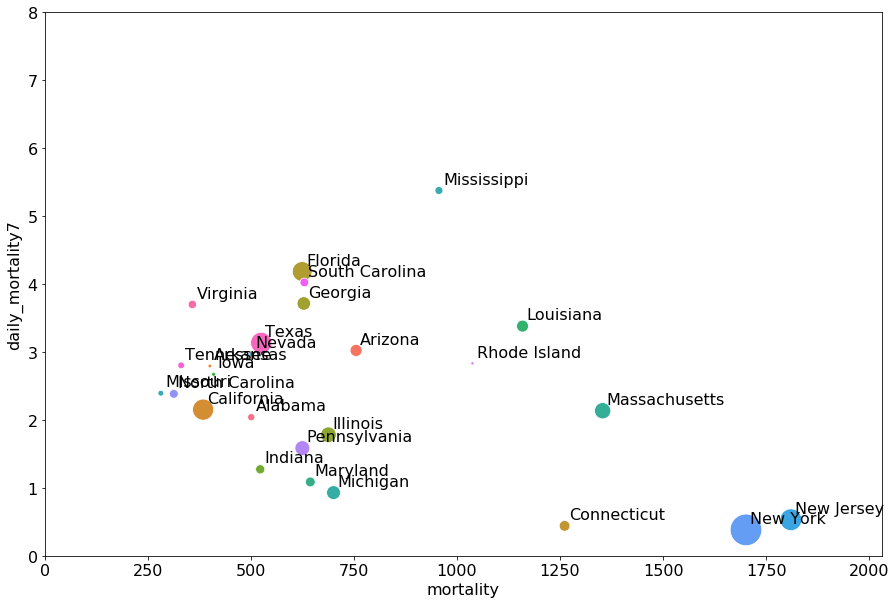

In [142]:
# sns.set()

world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 2.) | (ds_states['mortality'] > 400).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-100, None)).to_dataframe().reset_index()
# ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 8), xlim=(0, 2030))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    ax.annotate(record['location'].partition('US / ')[2], (record['mortality'] + 10, record['daily_mortality7'] + .1))

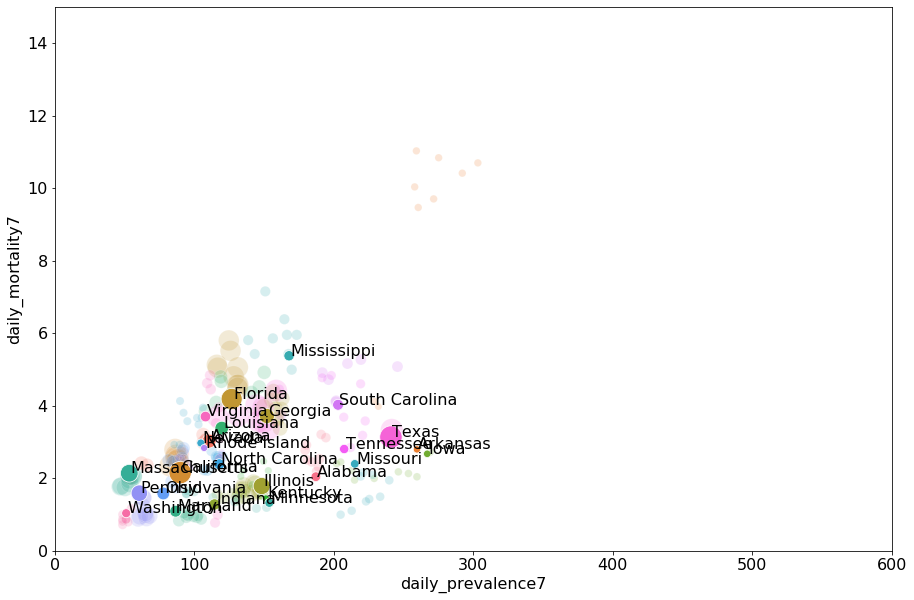

In [143]:
world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 1.) & (ds_states['mortality'] > 0).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-10, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(50, 500), legend=False)
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(50, 500), legend=False)
_ = ax.set(ylim=(0, 15), xlim=(0, 600))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_mortality7'] > 15:
        continue
    ax.annotate(record['location'].partition('US / ')[2], (record['daily_prevalence7'] + 1, record['daily_mortality7'] + .01))

In [144]:
#### DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-12', '2020-09-30')
XLIM = tuple(map(np.datetime64, EXTENT))

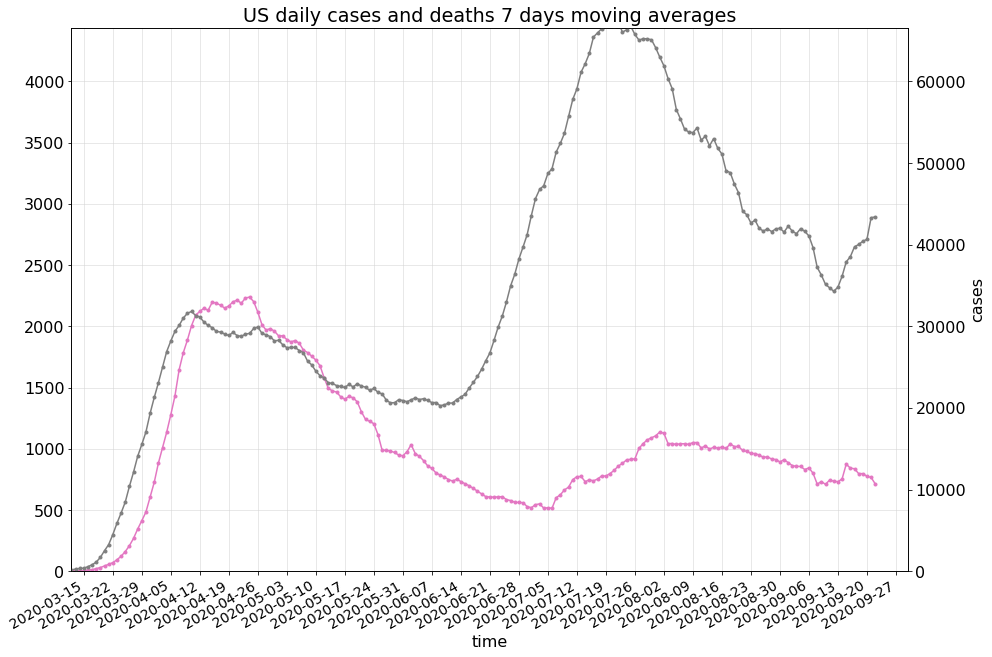

In [145]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax1.set(title=f'COVID-19 USA - Linear scale')
ax2 = ax1.twinx()

usa = ds_states.sum('location')

covid19.plot.plot_data(ax1, usa['daily_deaths'].rolling({'time': 7}).mean())
covid19.plot.plot_data(ax2, usa['daily_confirmed'].rolling({'time': 7}).mean())

ax1.set(ylim=(0, usa['population'] / 15 / 5_000), title='US daily cases and deaths 7 days moving averages') 
_ = ax2.set(ylim=(0, usa['population'] / 5_000), ylabel='cases') 


pippo
time              
2020-01-22     NaN
2020-01-23     NaN
2020-01-24     NaN
2020-01-25     NaN
2020-01-26     NaN
...            ...
2020-09-18  5591.0
2020-09-19  5589.0
2020-09-20  5438.0
2020-09-21  5372.0
2020-09-22  5005.0

[245 rows x 1 columns]

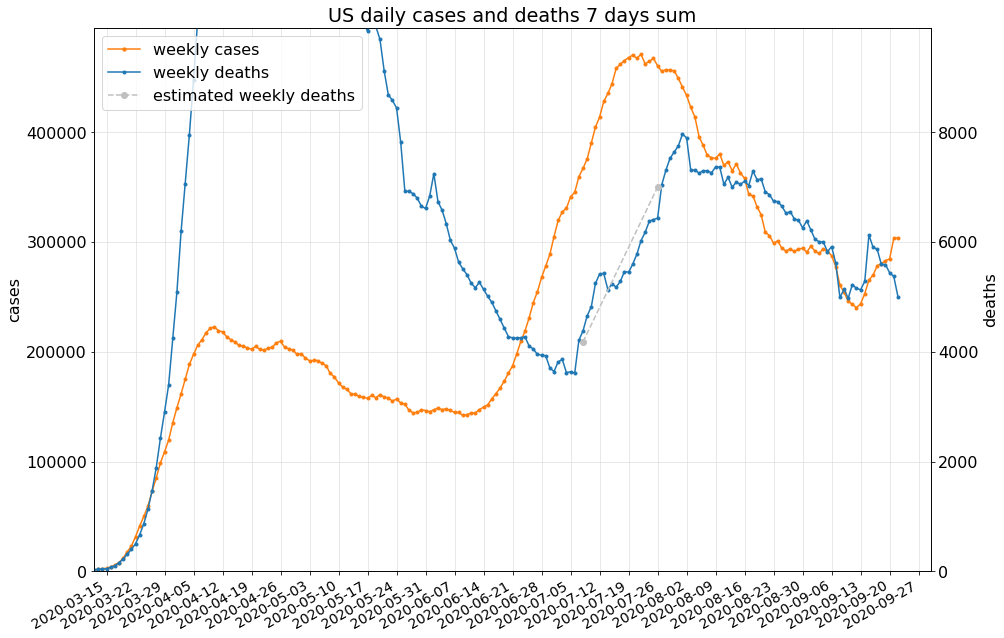

In [146]:
fig, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-12', '2020-09-30')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')

ax2.plot([0], [0], 'o-', color='tab:orange', label='weekly cases', markersize=3.25)
covid19.plot.plot_data(ax2, usa['daily_deaths'].rolling({'time': 7}).sum(), color='tab:blue', label='weekly deaths')
covid19.plot.plot_data(ax1, usa['daily_confirmed'].rolling({'time': 7}).sum(), color='tab:orange')
ax2.plot(tuple(map(np.datetime64, ['2020-07-08', '2020-07-26'])), [4180, 7000], 'o--', color='silver', label='estimated weekly deaths')


ax2.set(ylim=(0, 9900), title='US daily cases and deaths 7 days sum', ylabel='deaths') 
ax1.yaxis.set_label_position("left")
ax2.legend(loc='upper left')
_ = ax1.set(ylim=(0, 9900 * 50), ylabel='cases', xlabel='') 
usa['daily_deaths'].rolling({'time': 7}).sum().rename('pippo').to_dataframe()

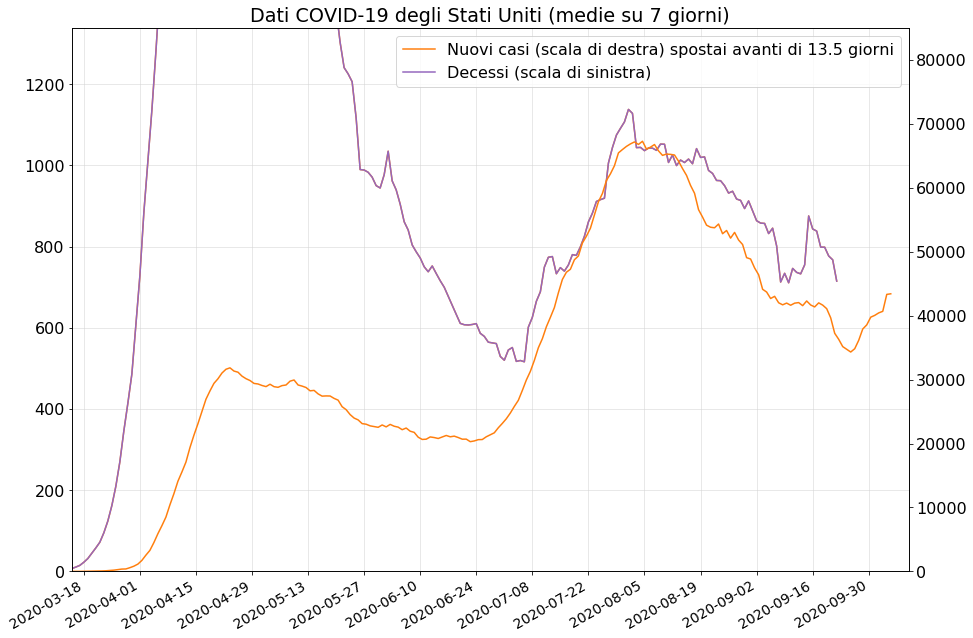

In [147]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-15', '2020-10-10')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')
usa['mortality'] = usa['deaths'] / usa['population'] * 1_000_000
usa['daily_mortality'] = usa['daily_deaths'] / usa['population'] * 1_000_000
usa['daily_mortality7'] = usa['daily_mortality'].rolling({'time': 7}).mean()
usa['daily_deaths7'] = usa['daily_deaths'].rolling({'time': 7}).mean()
usa['daily_prevalence'] = usa['daily_confirmed'] / usa['population'] * 1_000_000
usa['daily_prevalence7'] = usa['daily_prevalence'].rolling({'time': 7}).mean()
usa['daily_confirmed7'] = usa['daily_confirmed'].rolling({'time': 7}).mean()


covid19.plot.plot_data(ax2, usa['daily_confirmed7'], delay=13.5, color='tab:orange', marker=None)
covid19.plot.plot_data(ax1, usa['daily_deaths7'], label='Nuovi casi (scala di destra) spostai avanti di 13.5 giorni', color='tab:orange', marker=None)
covid19.plot.plot_data(ax1, usa['daily_deaths7'], label='Decessi (scala di sinistra)', color='tab:purple', date_interval=14, marker=None)
# covid19.plot.plot_data(ax2, usa['daily_prevalence7'])
ax1.set(ylim=(0, 85000. * 0.01575), ylabel='', xlabel='') 
ax1.set(title=f'Dati COVID-19 degli Stati Uniti (medie su 7 giorni)', ylabel='')
_ = ax2.set(ylim=(0, 85000.), ylabel='', xlabel='') 
ax1.legend()

In [148]:
usa.to_dataframe().tail(20)

population  deaths  confirmed   mortality  daily_deaths  \
time                                                                  
2020-09-03   332865687  186790    6150016  561.157269        1070.0   
2020-09-04   332865687  187755    6200518  564.056337         965.0   
2020-09-05   332865687  188538    6244970  566.408637         783.0   
2020-09-06   332865687  188941    6276365  567.619335         403.0   
2020-09-07   332865687  189208    6300622  568.421461         267.0   
2020-09-08   332865687  189653    6327009  569.758336         445.0   
2020-09-09   332865687  190859    6360212  573.381419        1206.0   
2020-09-10   332865687  191766    6396100  576.106242         907.0   
2020-09-11   332865687  192979    6443652  579.750354        1213.0   
2020-09-12   332865687  193693    6485123  581.895364         714.0   
2020-09-13   332865687  194071    6520122  583.030957         378.0   
2020-09-14   332865687  194493    6553652  584.298735         422.0   
2020-09-15   332865687  195781    6592342  588.168164        1288.0   
2020-09-16   332865687  196763    6630051  591.118303         982.0   
2020-09-17   332865687  197633    6674411  593.731970         870.0   
2020-09-18   332865687  198570    6723933  596.546919         937.0   
2020-09-19   332865687  199282    6768119  598.685920         712.0   
2020-09-20   332865687  199509    6804814  599.367877         227.0   
2020-09-21   332865687  199865    6856884  600.437377         356.0   
2020-09-22   332865687  200786    6896218  603.204259         921.0   

            daily_mortality  daily_mortality7  daily_confirmed  \
time                                                             
2020-09-03         3.214510          2.577187          43862.0   
2020-09-04         2.899067          2.574612          50502.0   
2020-09-05         2.352300          2.499507          44452.0   
2020-09-06         1.210699          2.539420          31395.0   
2020-09-07         0.802125          2.408093          24257.0   
2020-09-08         1.336876          2.141147          26387.0   
2020-09-09         3.623083          2.205523          33203.0   
2020-09-10         2.724823          2.135567          35888.0   
2020-09-11         3.644112          2.242003          47552.0   
2020-09-12         2.145009          2.212390          41471.0   
2020-09-13         1.135593          2.201660          34999.0   
2020-09-14         1.267779          2.268182          33530.0   
2020-09-15         3.869429          2.629975          38690.0   
2020-09-16         2.950139          2.533841          37709.0   
2020-09-17         2.613667          2.517961          44360.0   
2020-09-18         2.814949          2.399509          49522.0   
2020-09-19         2.139001          2.398651          44186.0   
2020-09-20         0.681957          2.333846          36695.0   
2020-09-21         1.069500          2.305520          52070.0   
2020-09-22         2.766882          2.148014          39334.0   

            daily_prevalence  daily_prevalence7  daily_deaths7  \
time                                                             
2020-09-03        131.770866         124.255609     857.857143   
2020-09-04        151.718852         126.156848     857.000000   
2020-09-05        133.543353         125.101939     832.000000   
2020-09-06         94.317321         123.428162     845.285714   
2020-09-07         72.873237         119.117114     801.571429   
2020-09-08         79.272214         111.857644     712.714286   
2020-09-09         99.748942         109.034969     734.142857   
2020-09-10        107.815258         105.612740     710.857143   
2020-09-11        142.856419         104.346678     746.285714   
2020-09-12        124.587789         103.067311     736.428571   
2020-09-13        105.144511         104.614053     732.857143   
2020-09-14        100.731320         108.593779     755.000000   
2020-09-15        116.233068         113.873901     875.428571   
2020-0

In [149]:
STATES_FIT_PARAMS = {
    'US / New York': {
        'deaths': ['2020-03-22', '2020-04-04'],
    },
    'US / New Jersey': {
        'deaths': [None, '2020-04-05', '2020-04-05'],
    },
    'US / Connecticut': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Massachusetts': {
        'deaths': [None, '2020-04-07'],
    },
    'US / Louisiana': {
        'deaths': [None, '2020-04-01'],
    },
    'US / District of Columbia': {
        'deaths': [None, '2020-04-01'],
    },
    'US / Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US / Rhode Island': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Pennsylvania': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Maryland': {
        'deaths': [None, None],
    },
    'US / Illinois': {
        'deaths': [None, '2020-04-10'],
    },
    'US / Indiana': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Colorado': {
        'deaths': [None, None],
    },
    'US / Washington': {
        'deaths': [None, '2020-03-26', '2020-04-10'],
    },
    'US / Georgia': {
        'deaths': [None, '2020-04-10'],
    },
    'US / California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US / Florida': {
        'deaths': [None, None],
    },
    'US / Delaware': {
        'deaths': [None, None],
    },
    'US / Nebraska': {
        'deaths': [None, None],
    },
}

In [150]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        ds = ds_states.sel(location=region)
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)
        if 'daily_' + kind in ds:
            kinf = 'daily_' + kind 
            region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)


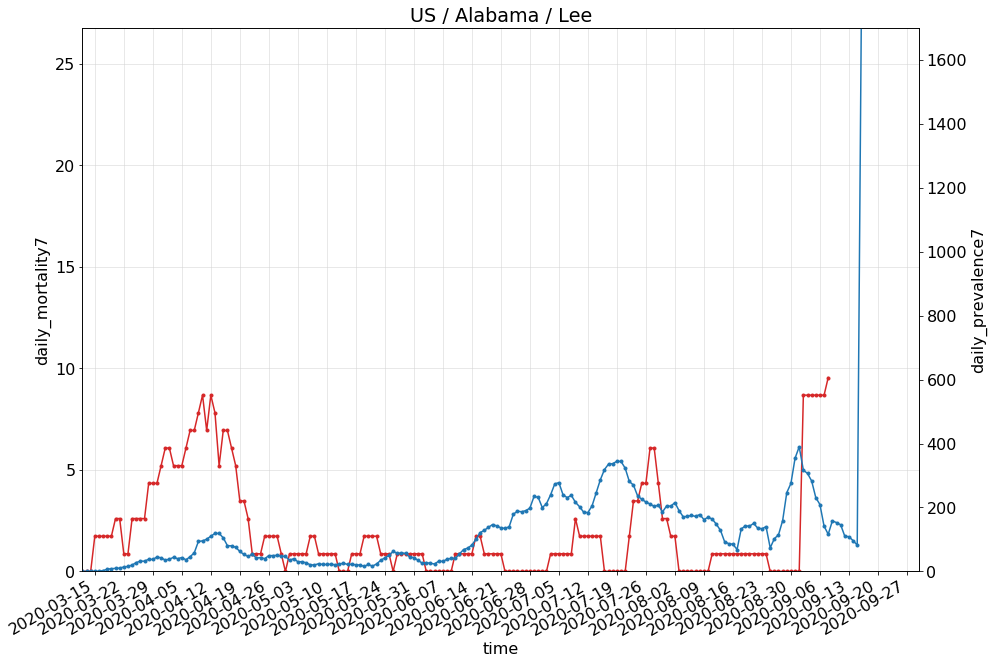

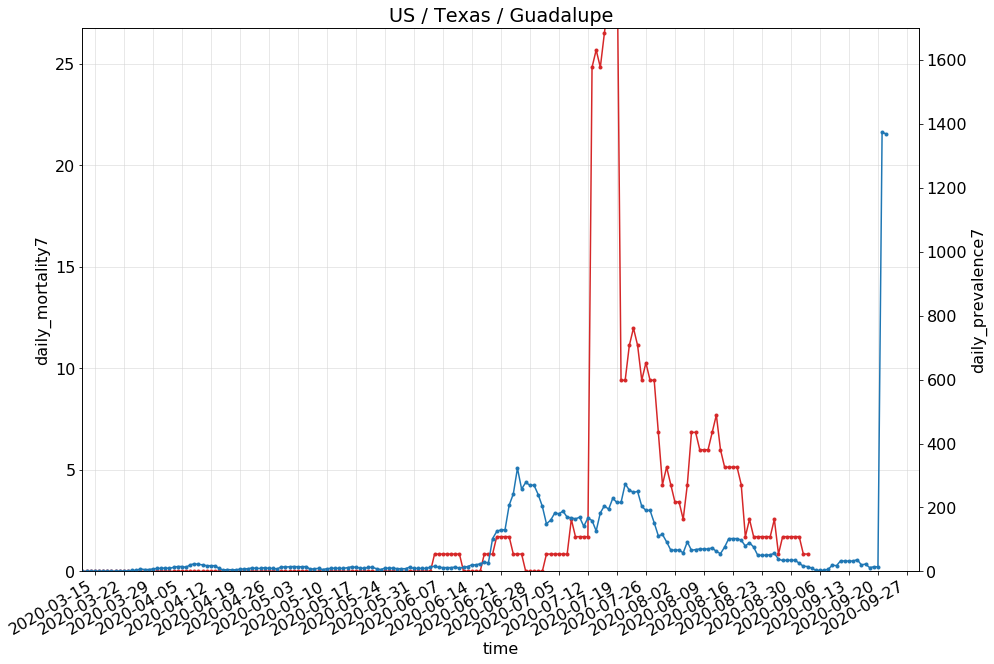

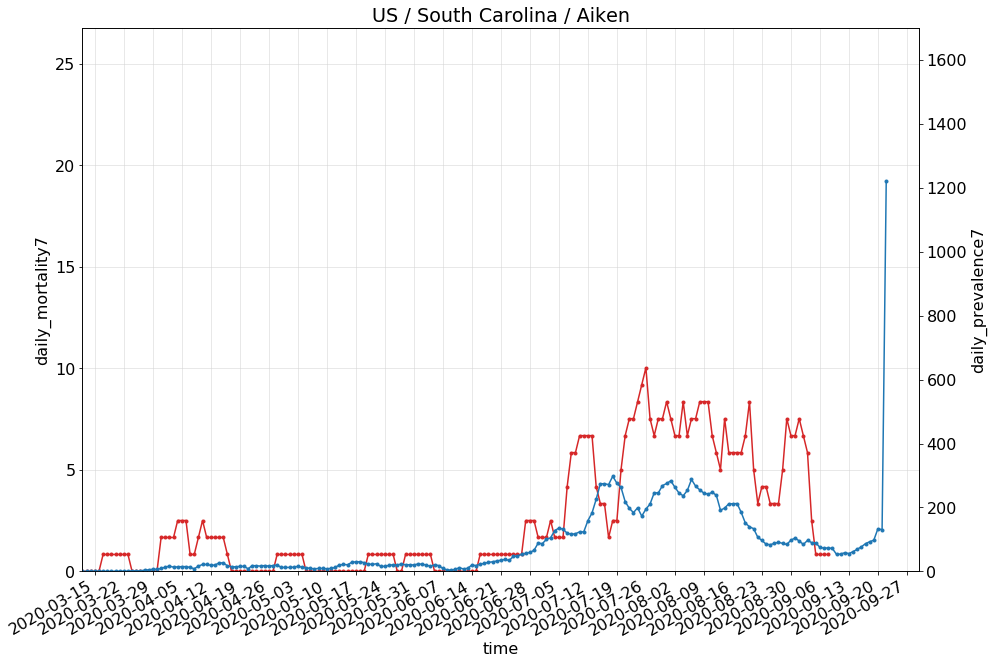

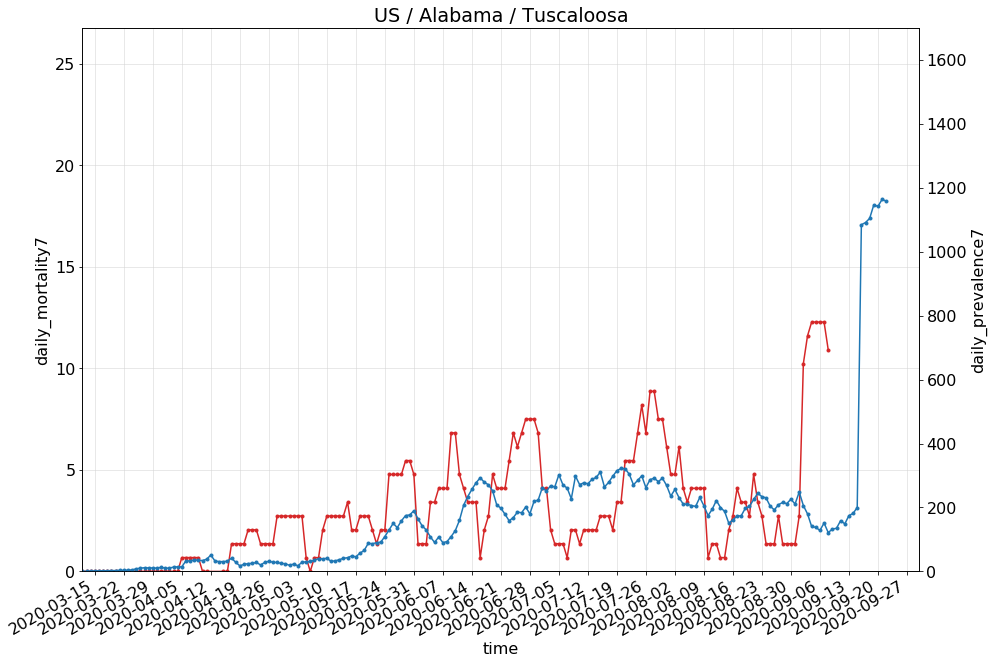

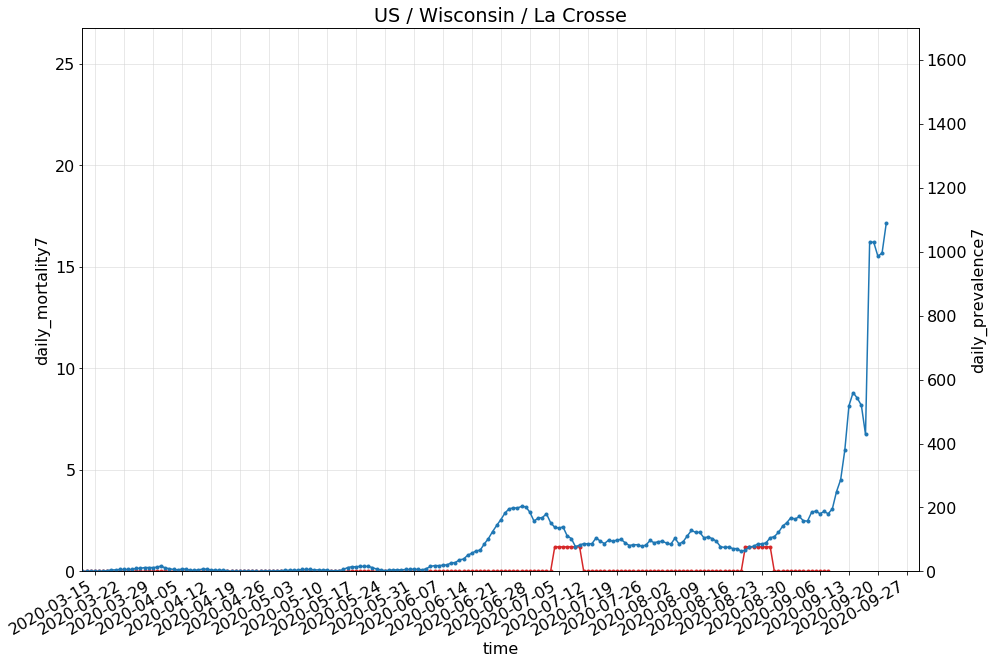

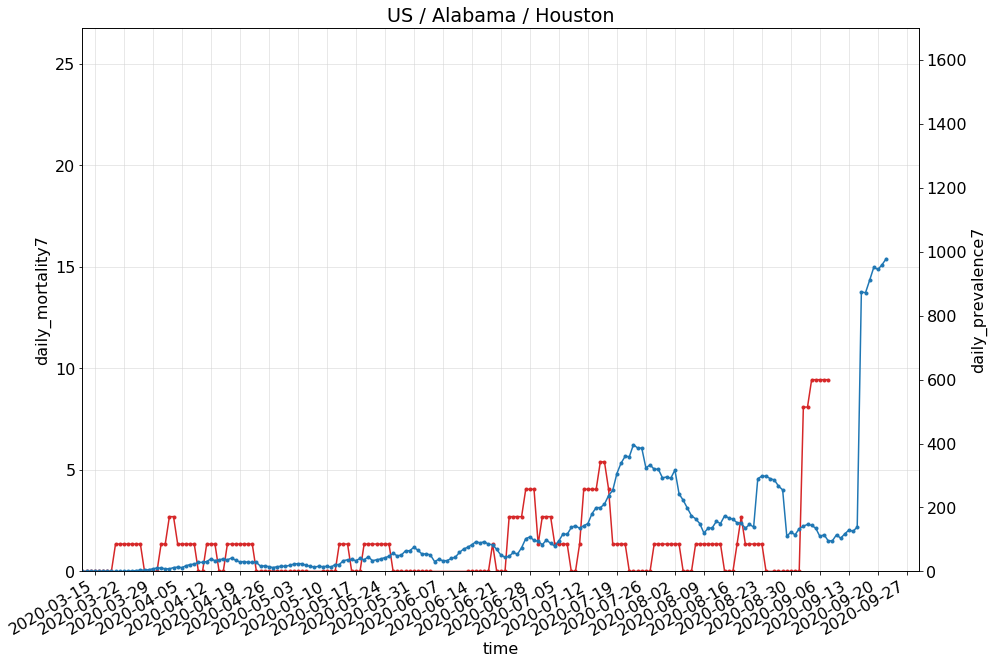

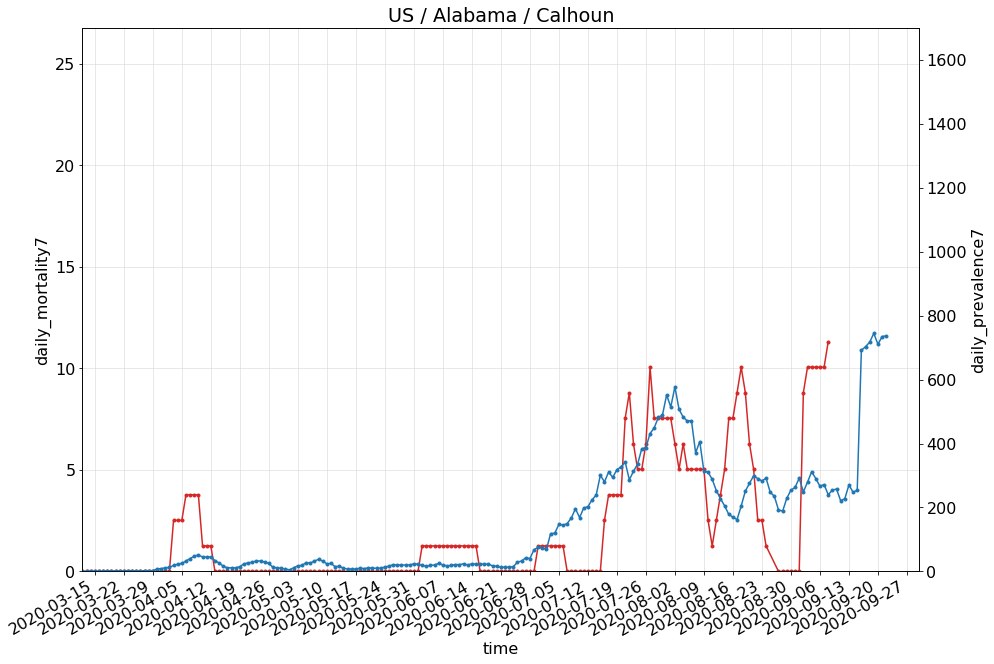

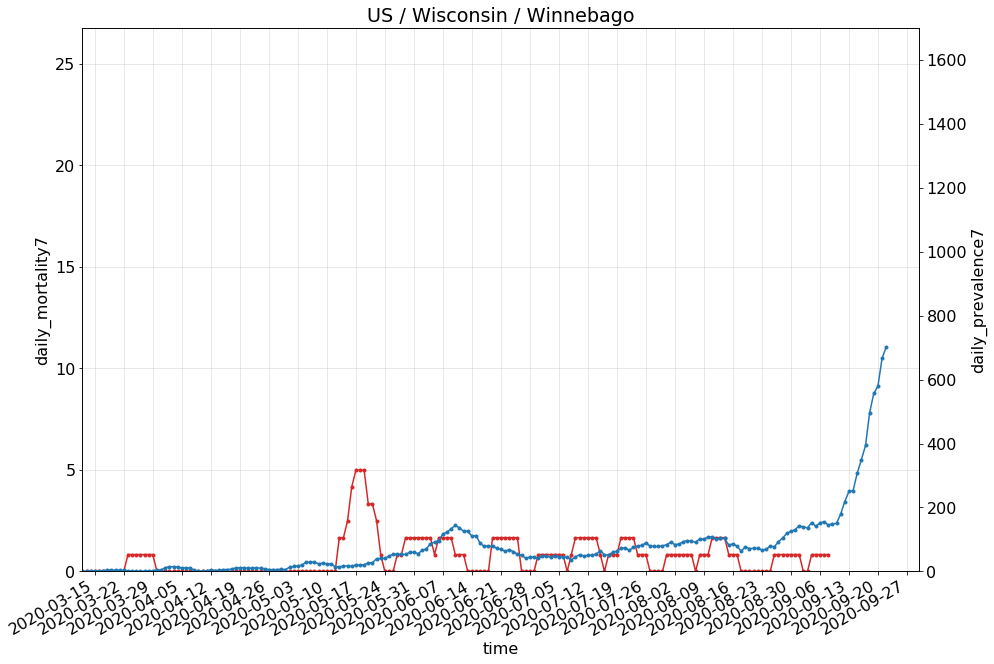

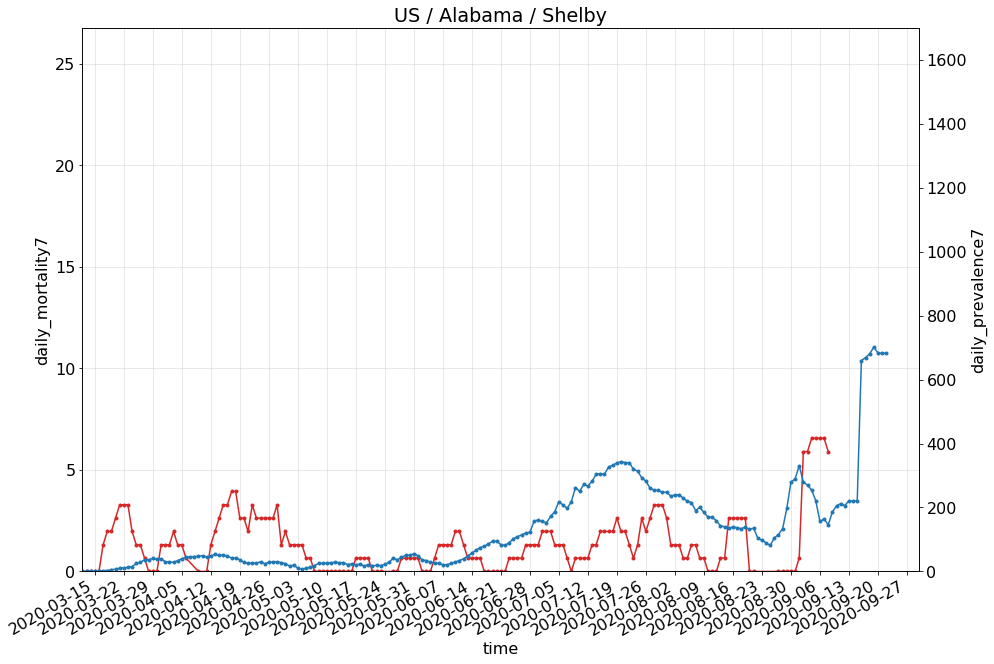

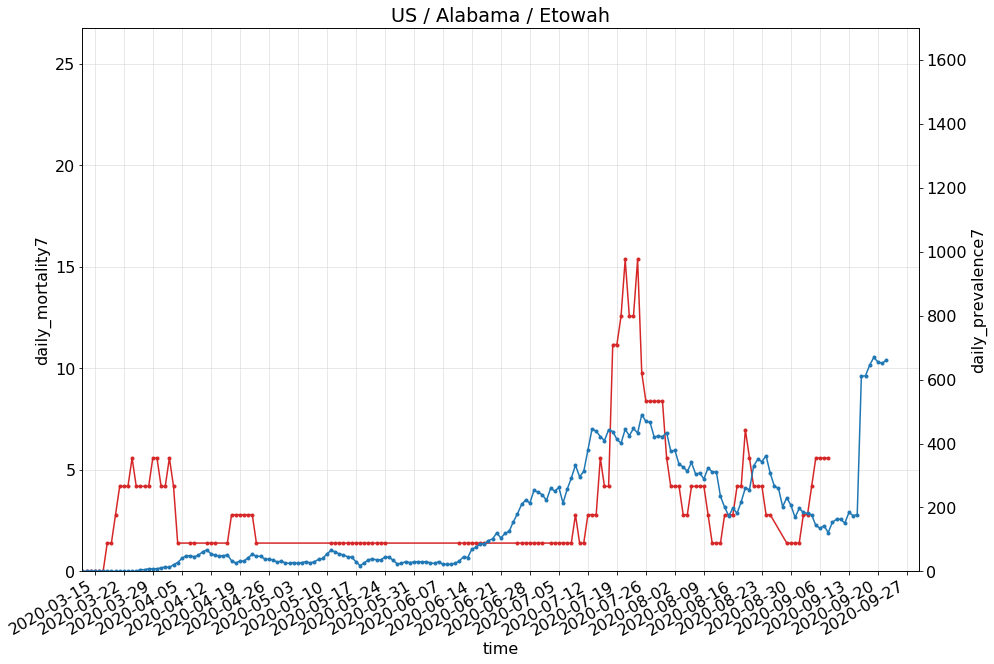

In [151]:
tmp = ds_counties.sortby(-ds_counties['daily_prevalence7'].isel(time=-1))
for location in list(tmp.sel(location=tmp['population'] > 100_000).location.values)[:10]:
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_counties.sel(location=location)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 1700. * 0.01575), title=location)
    ax2.set(ylim=(0, 1700.), title=None)

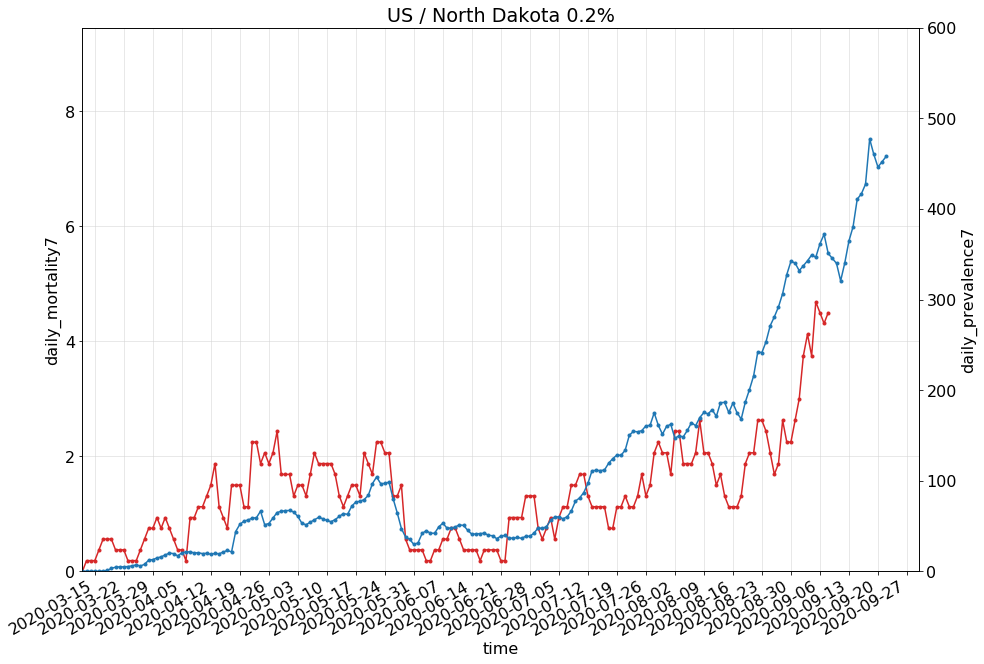

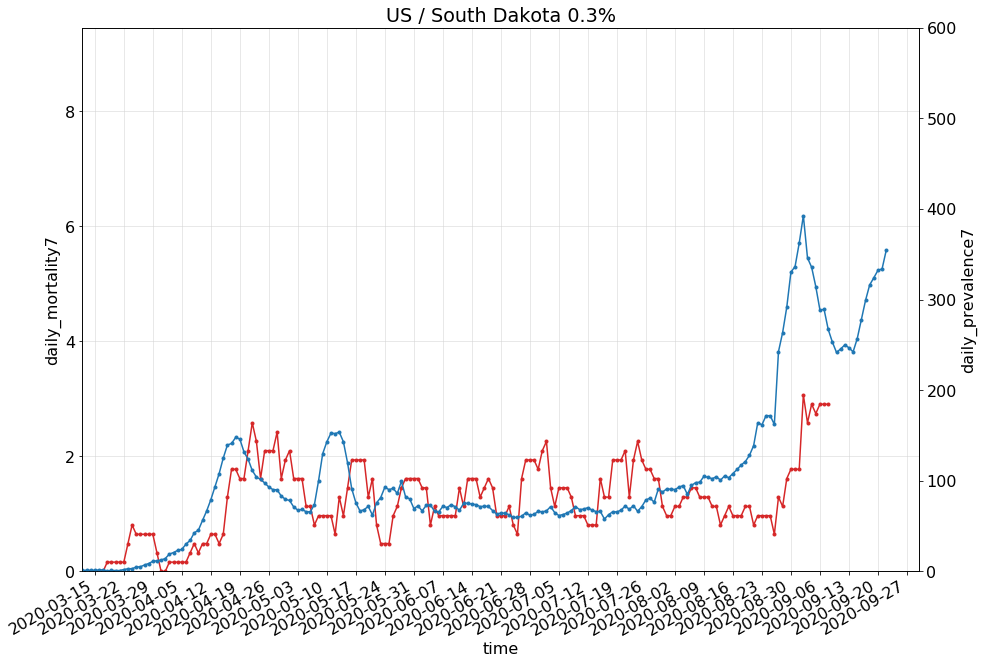

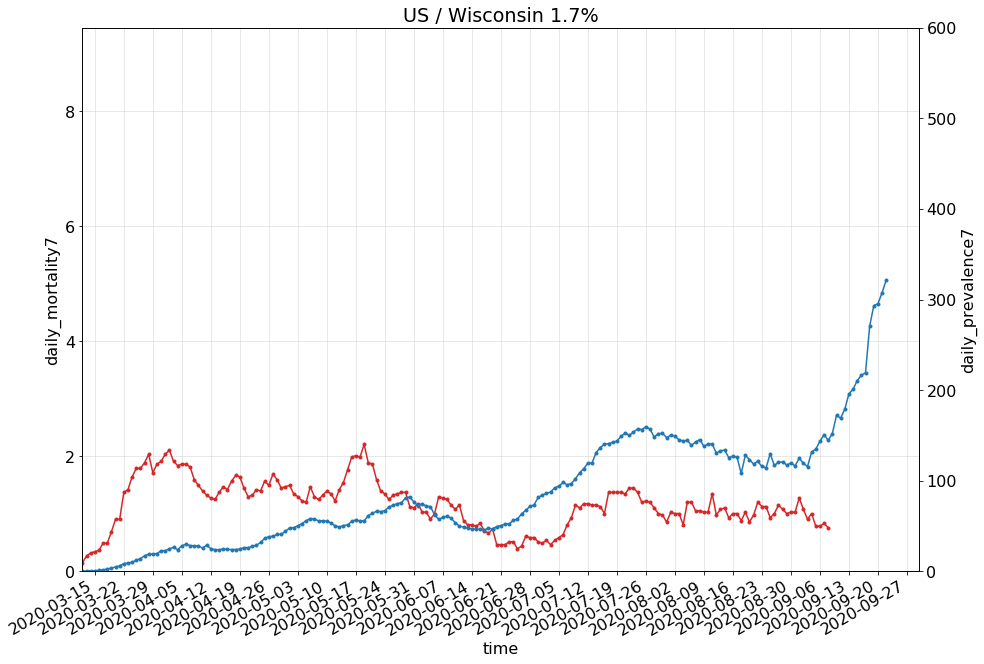

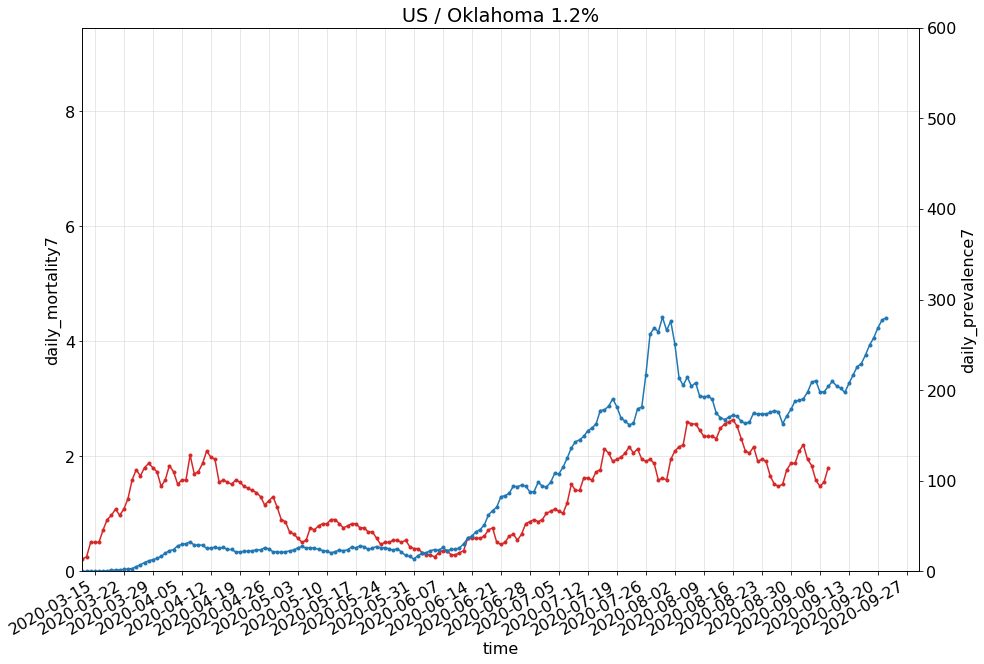

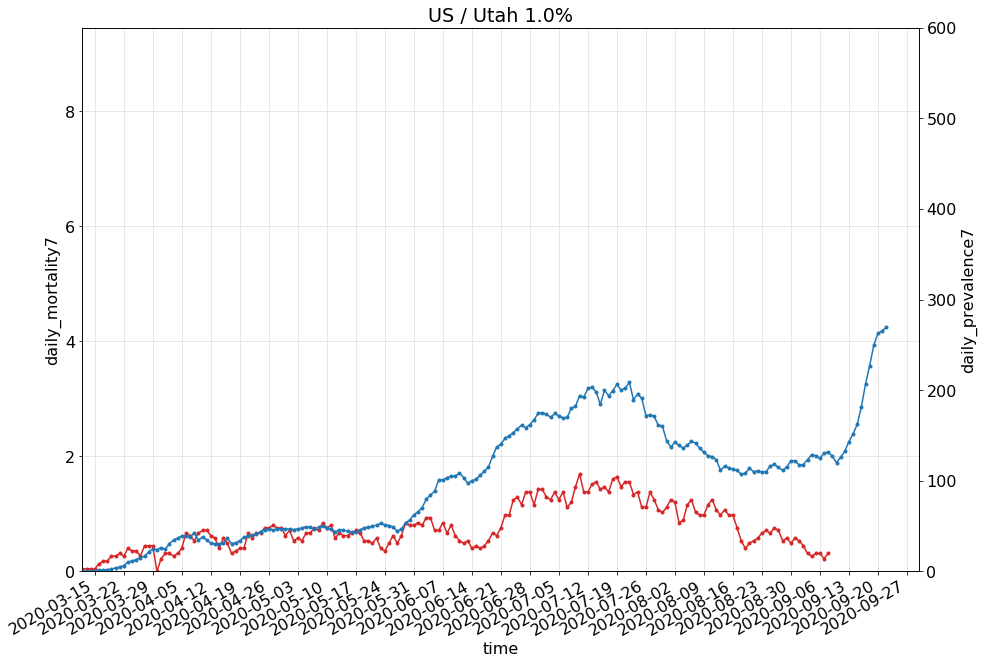

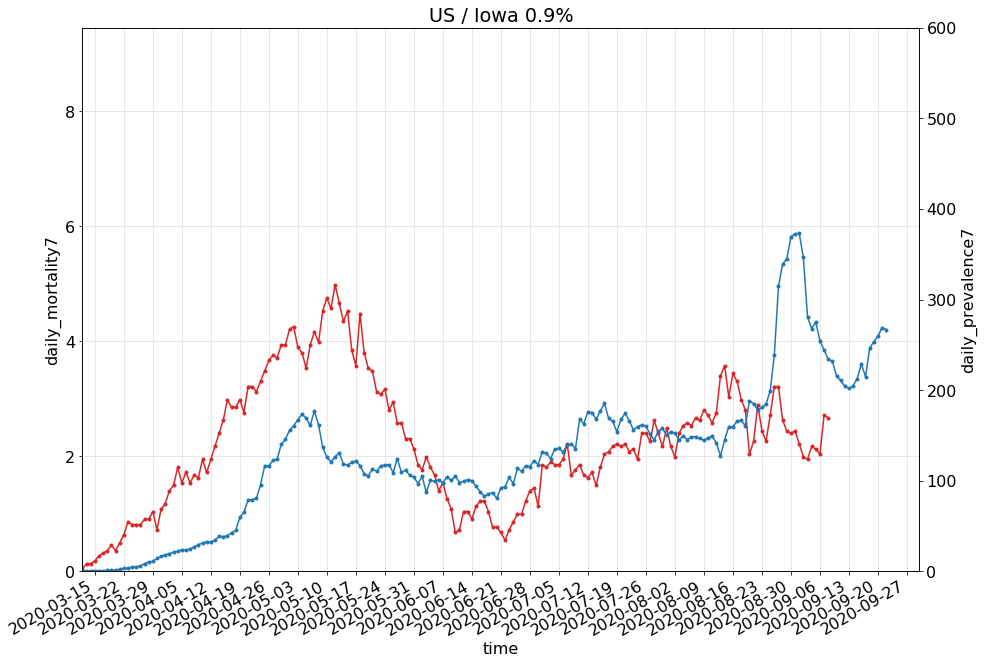

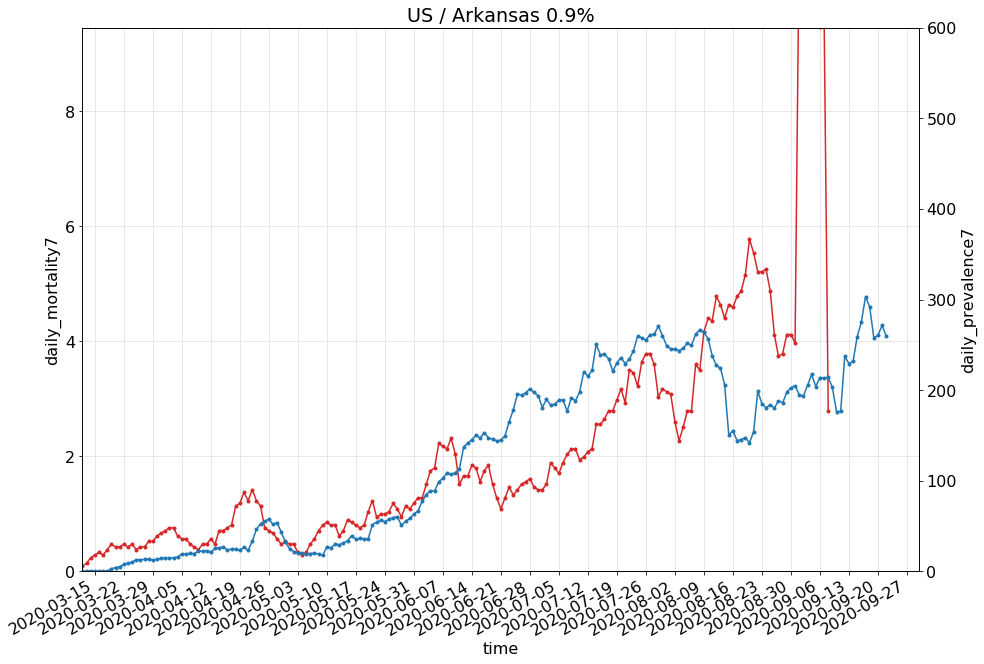

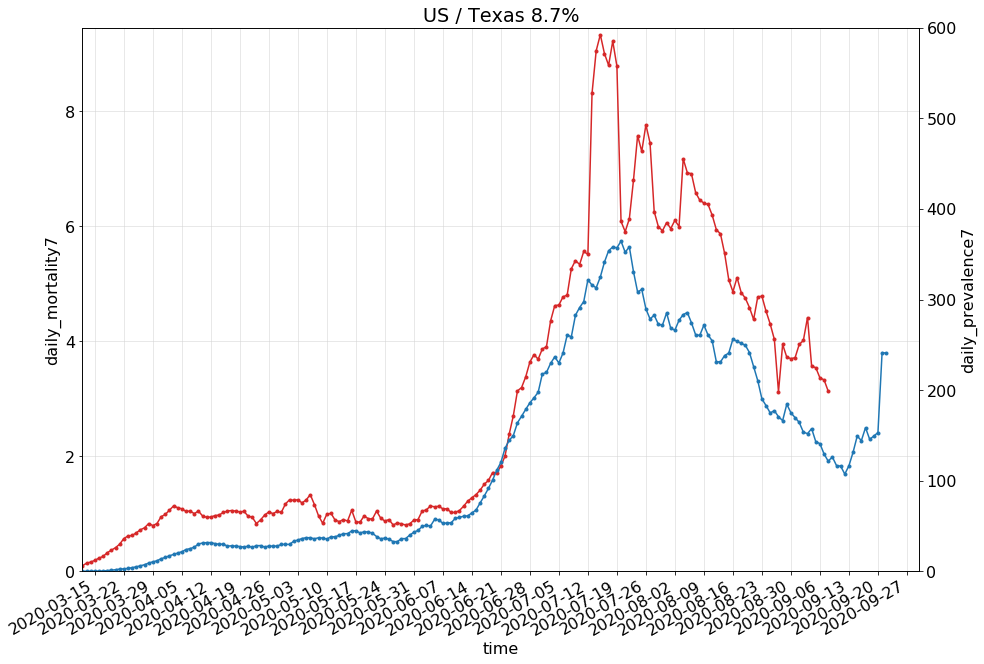

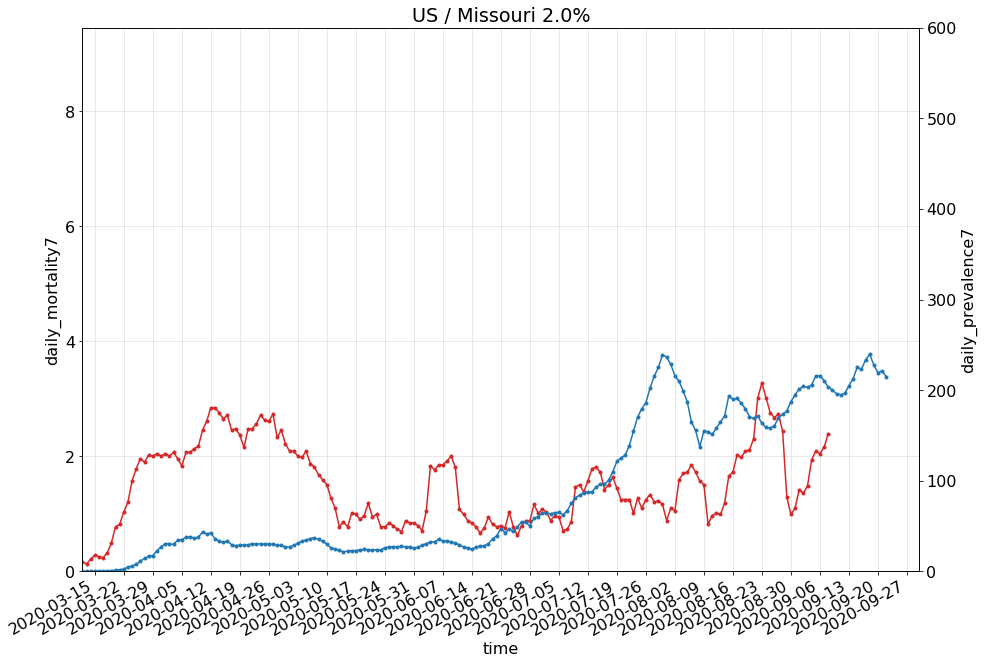

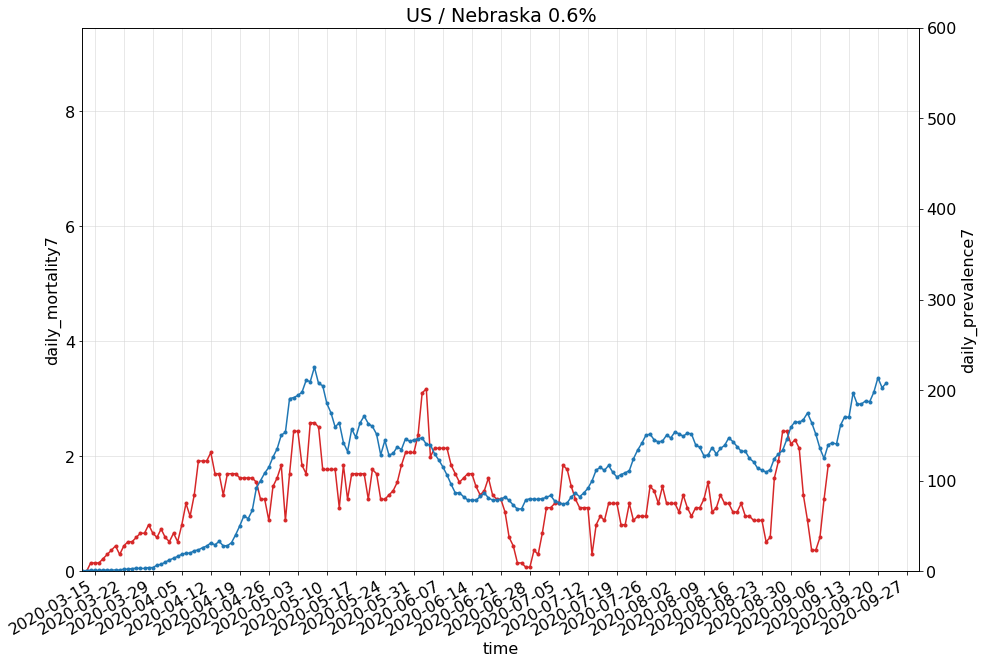

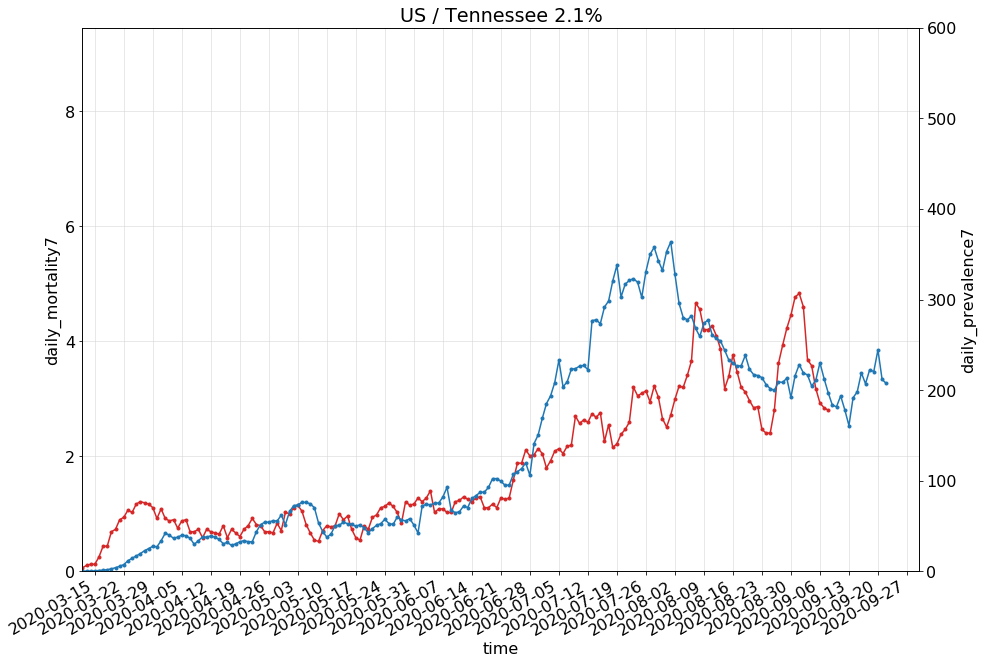

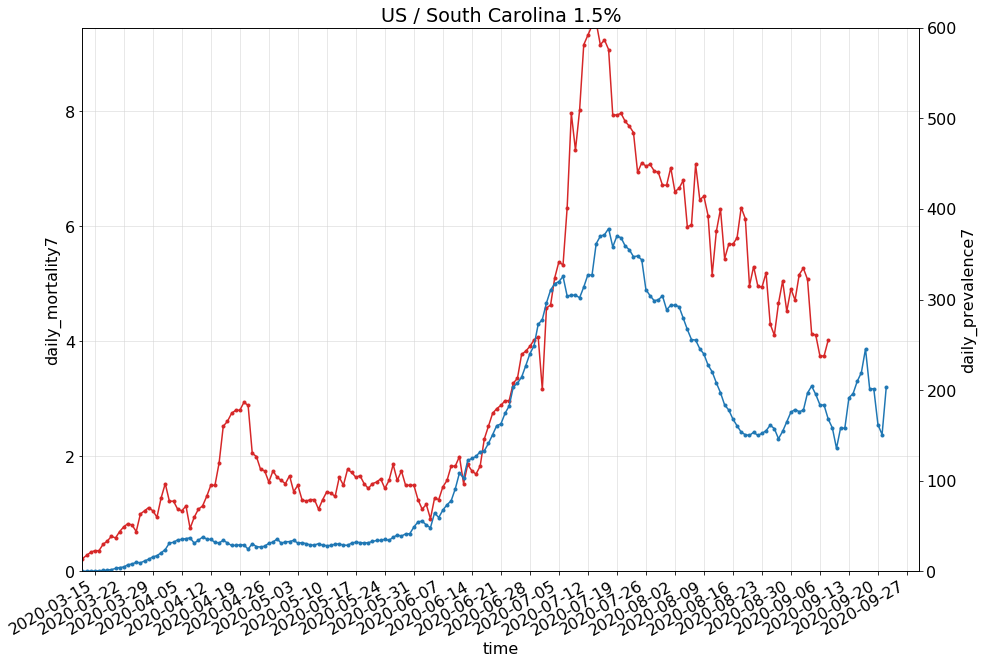

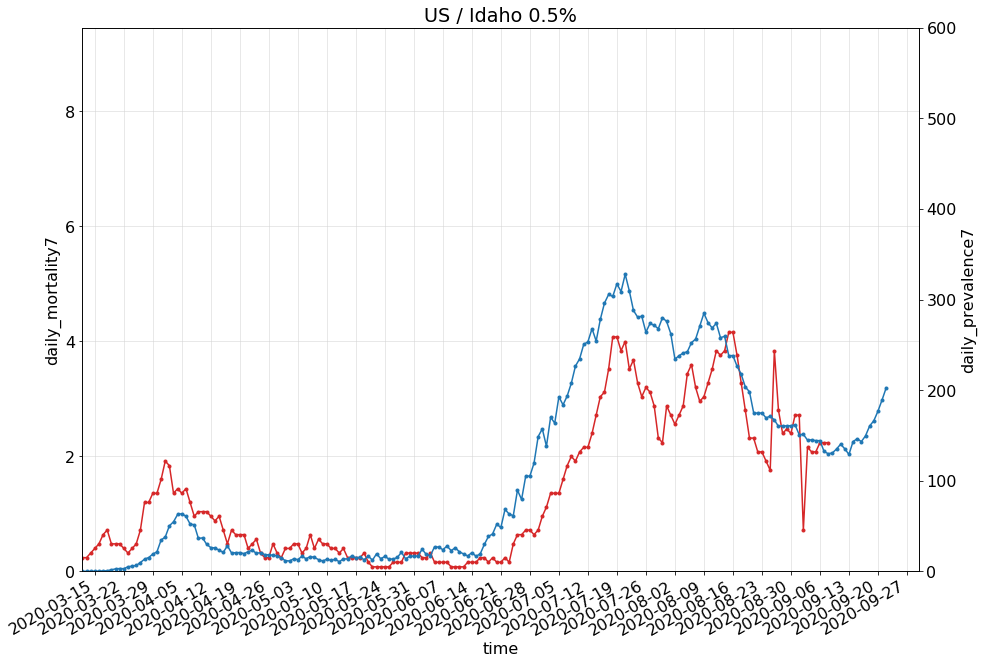

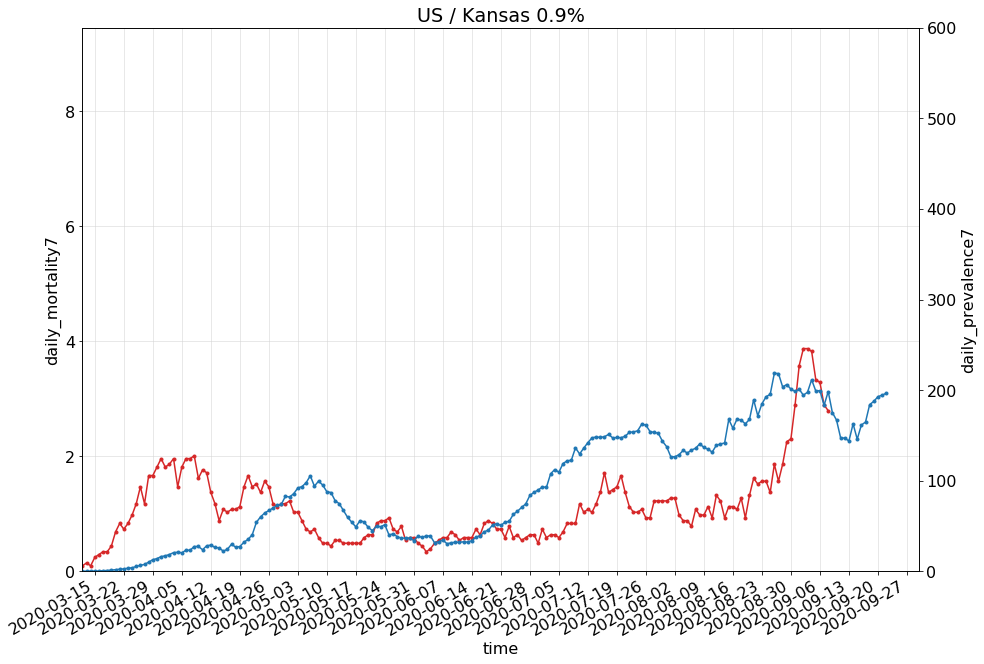

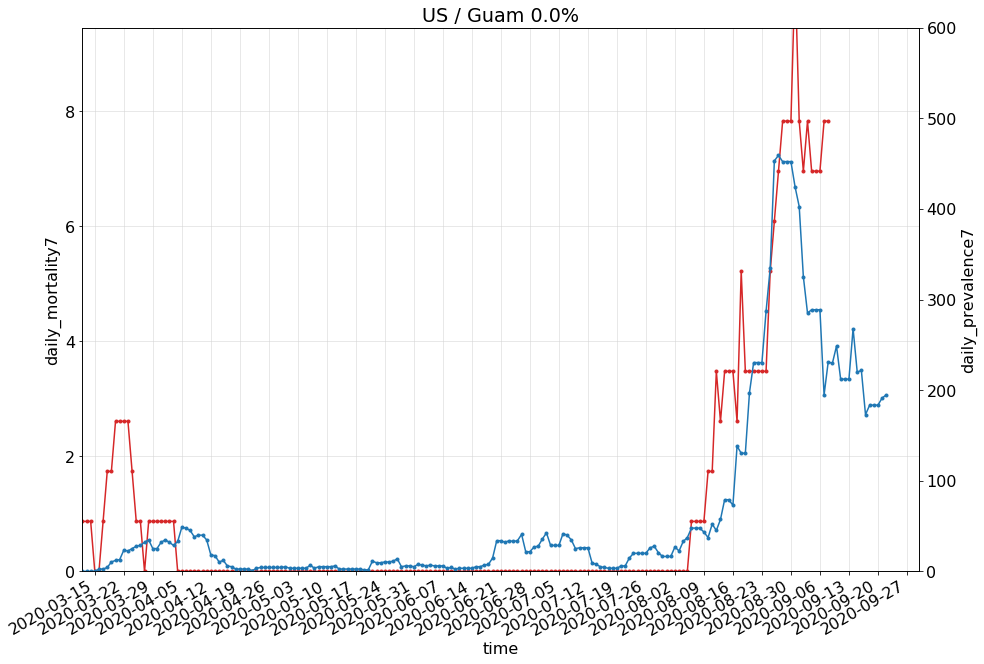

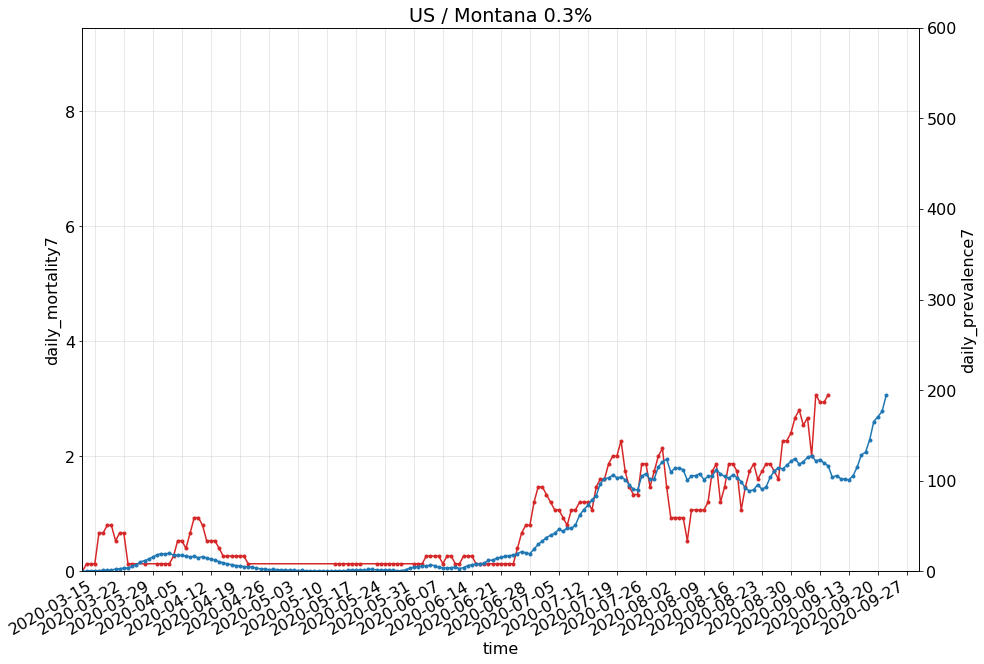

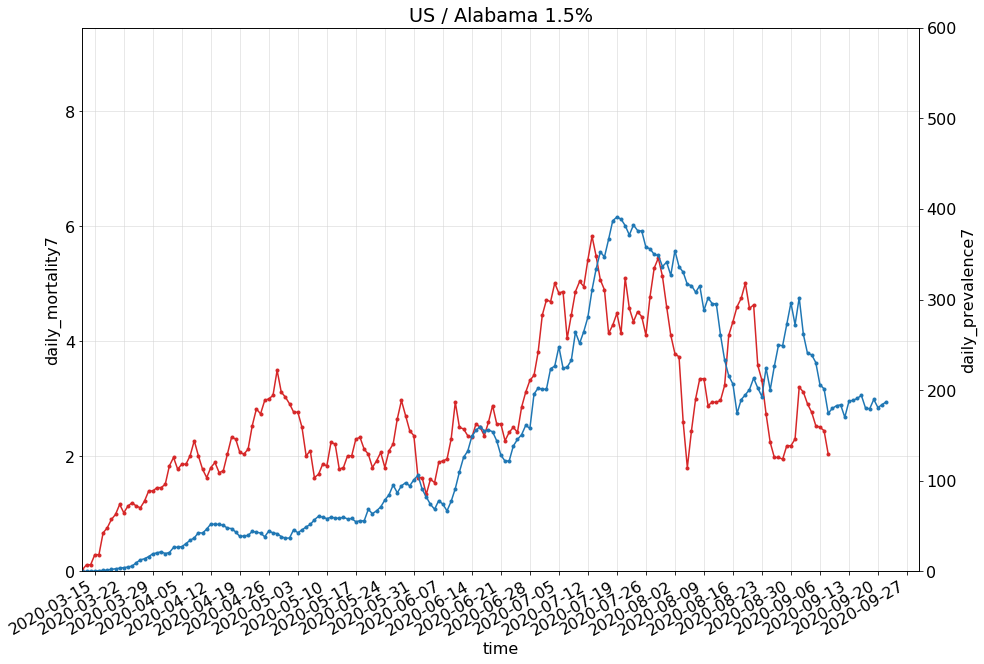

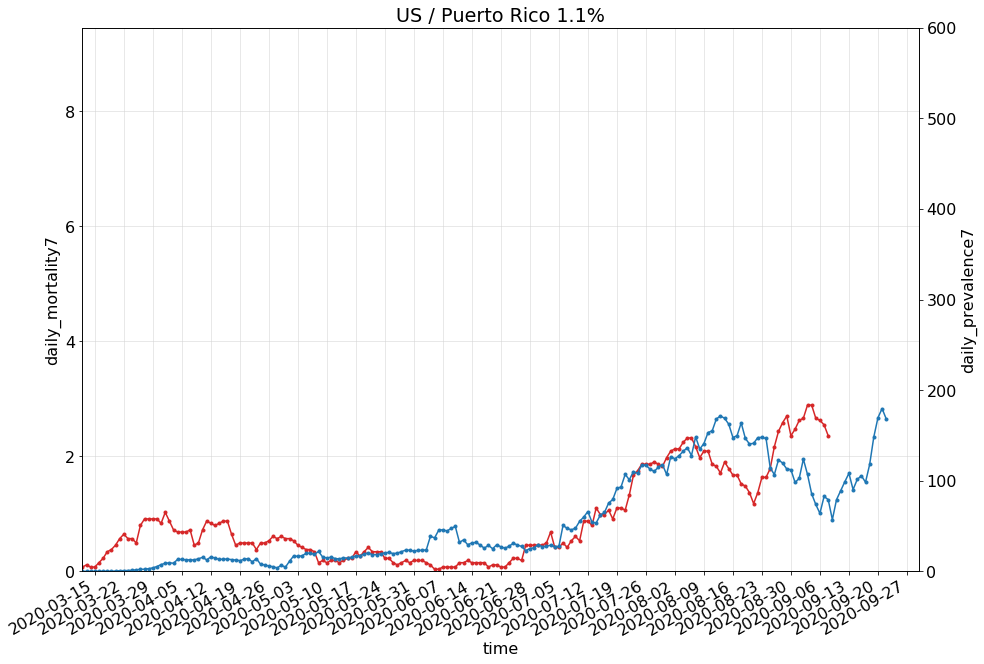

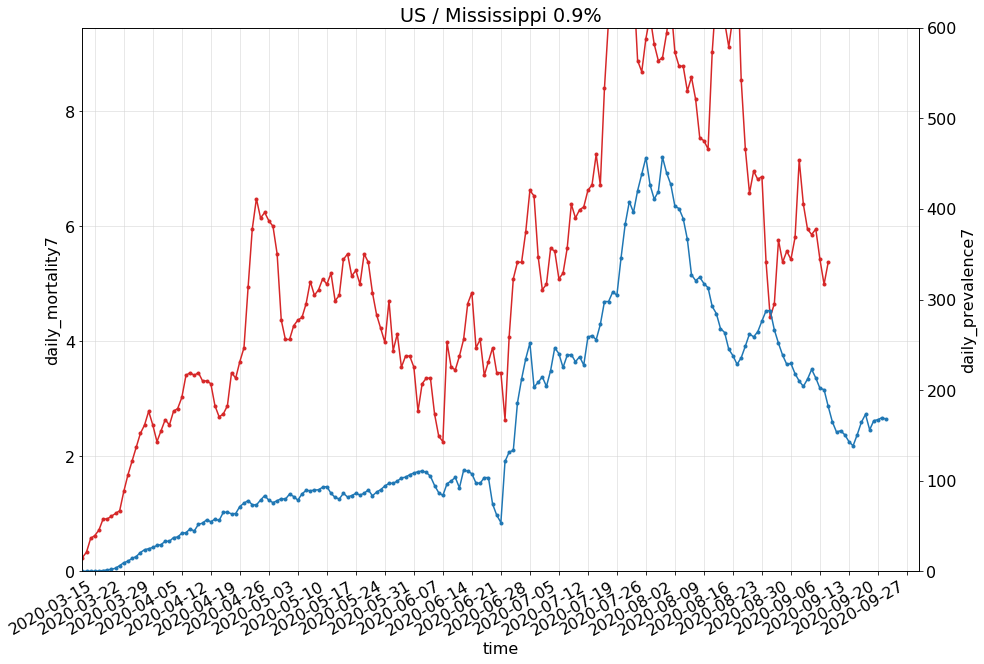

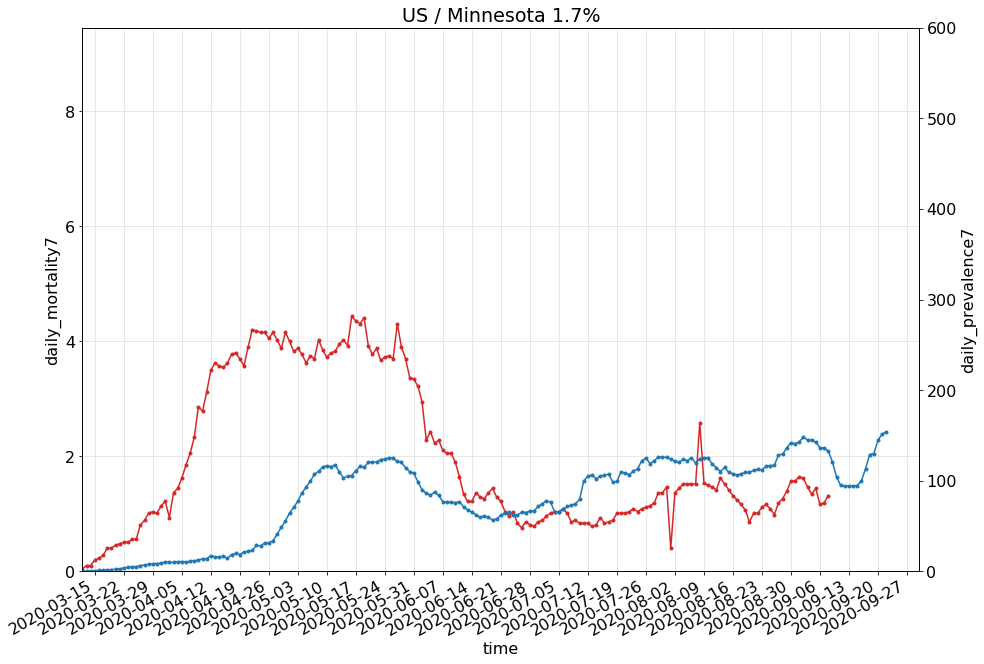

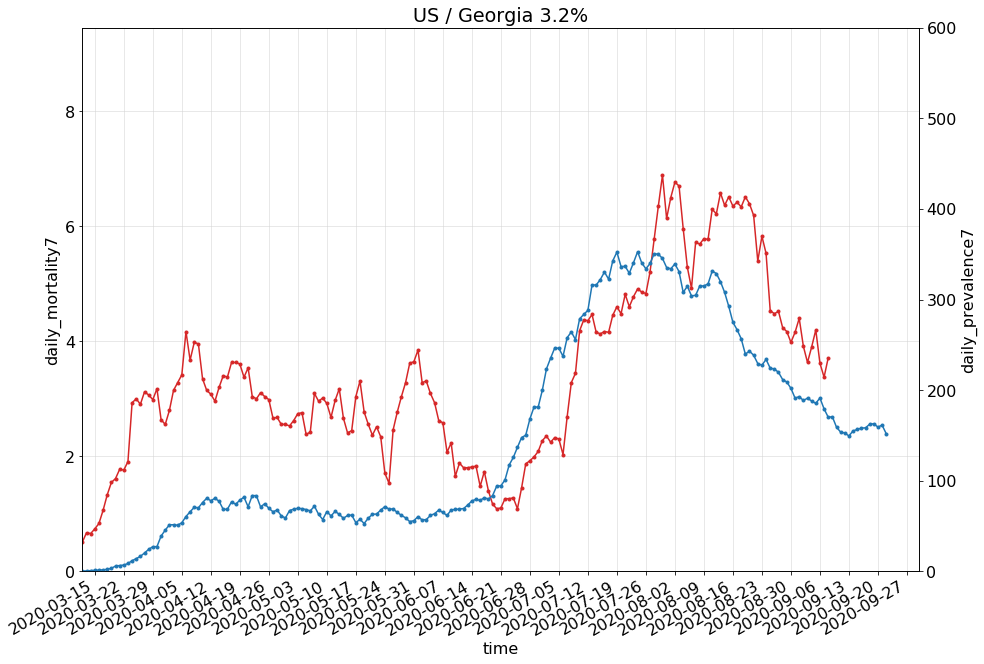

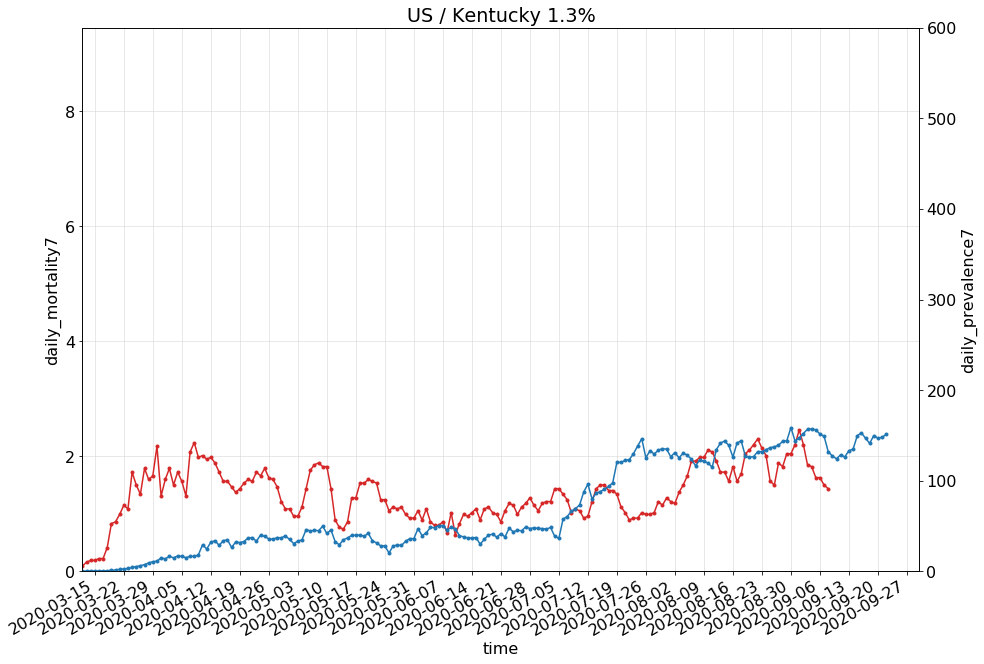

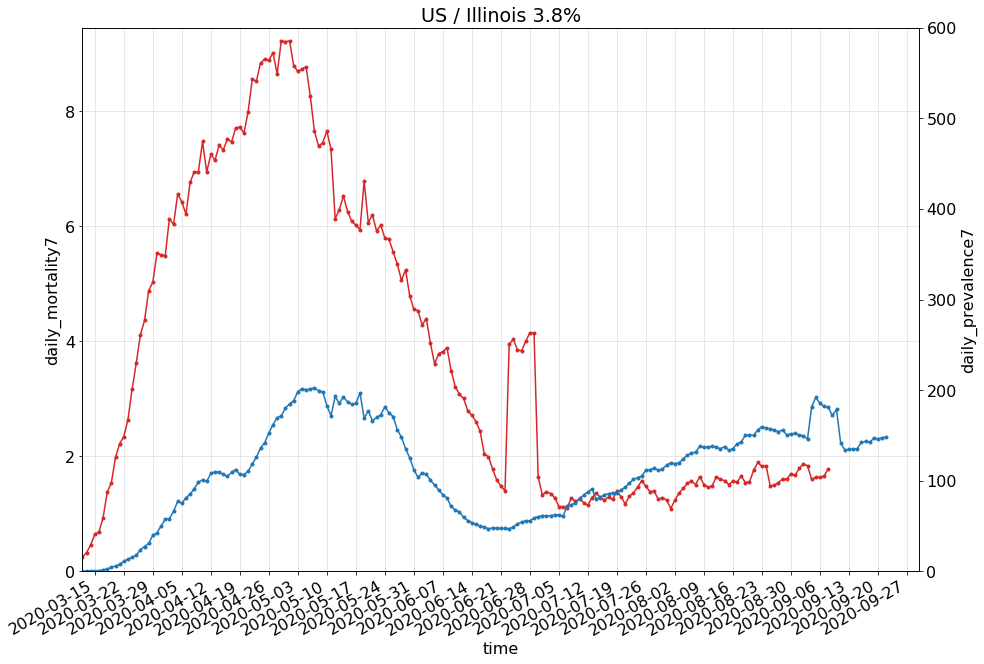

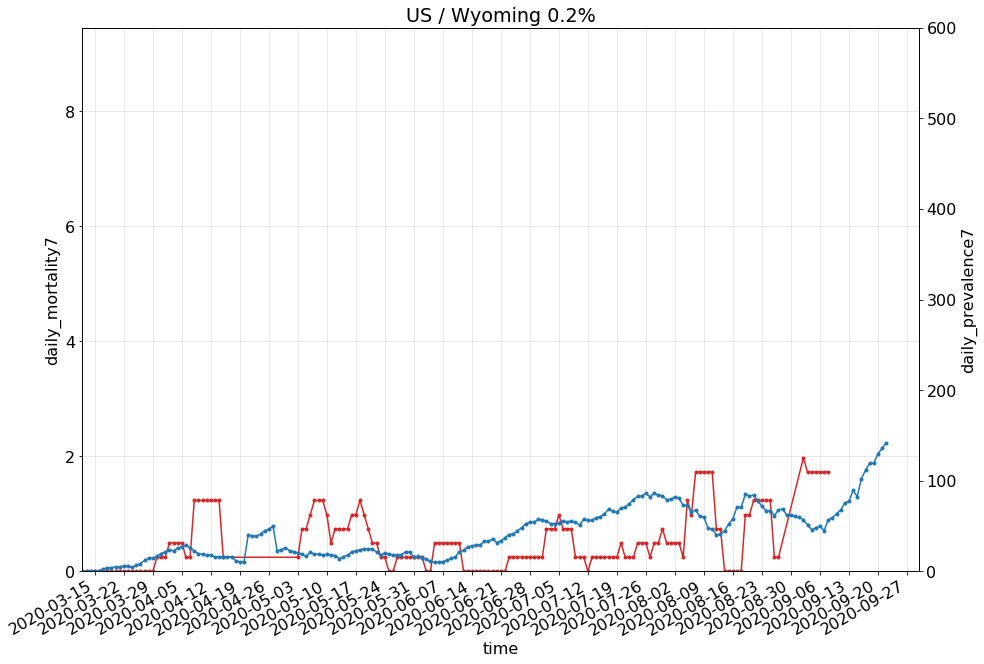

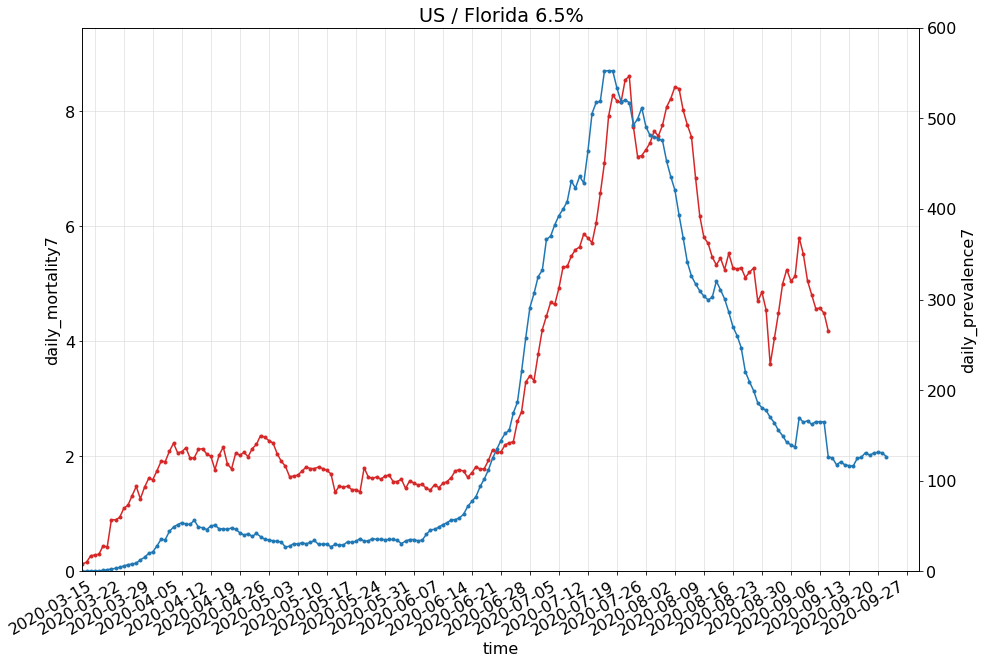

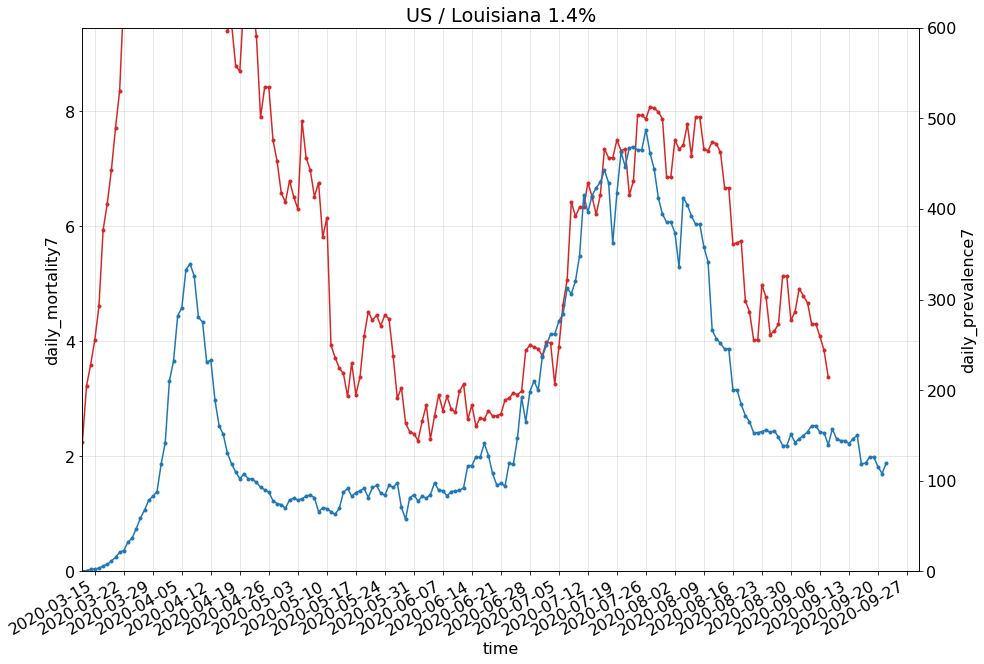

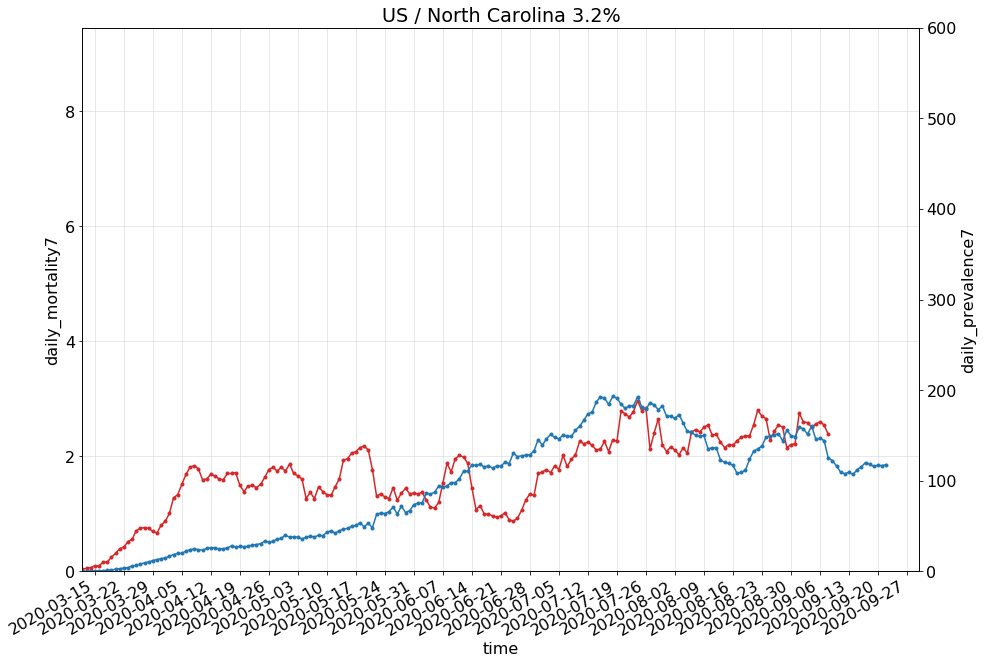

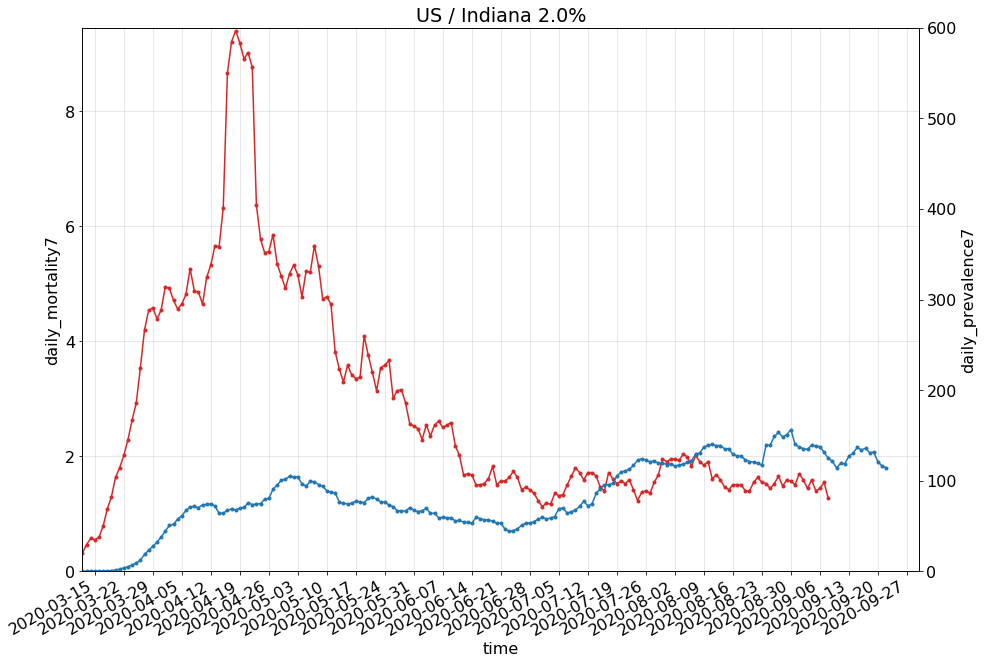

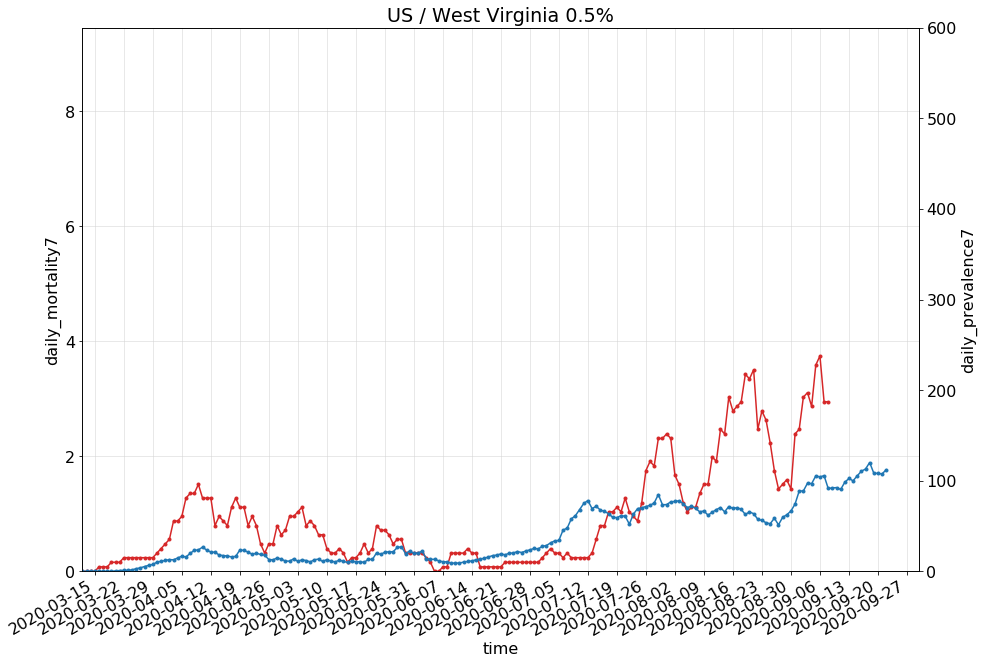

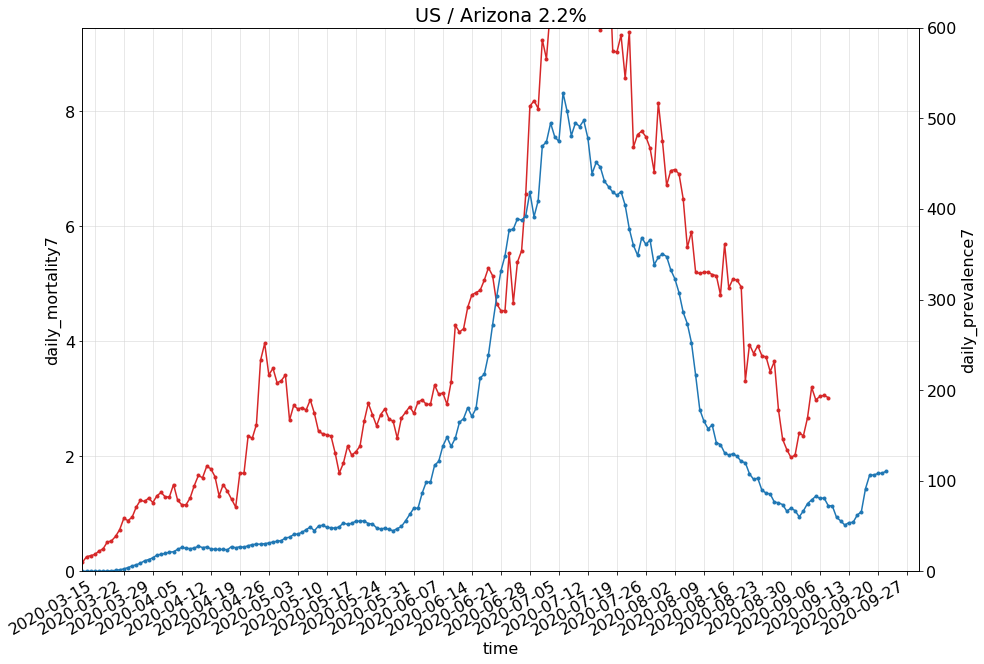

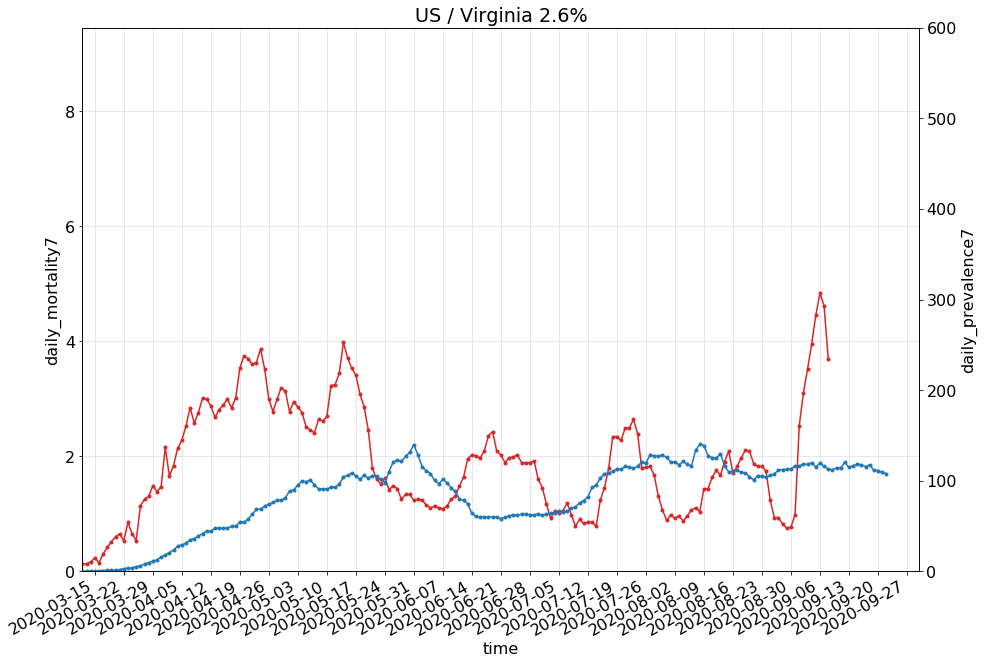

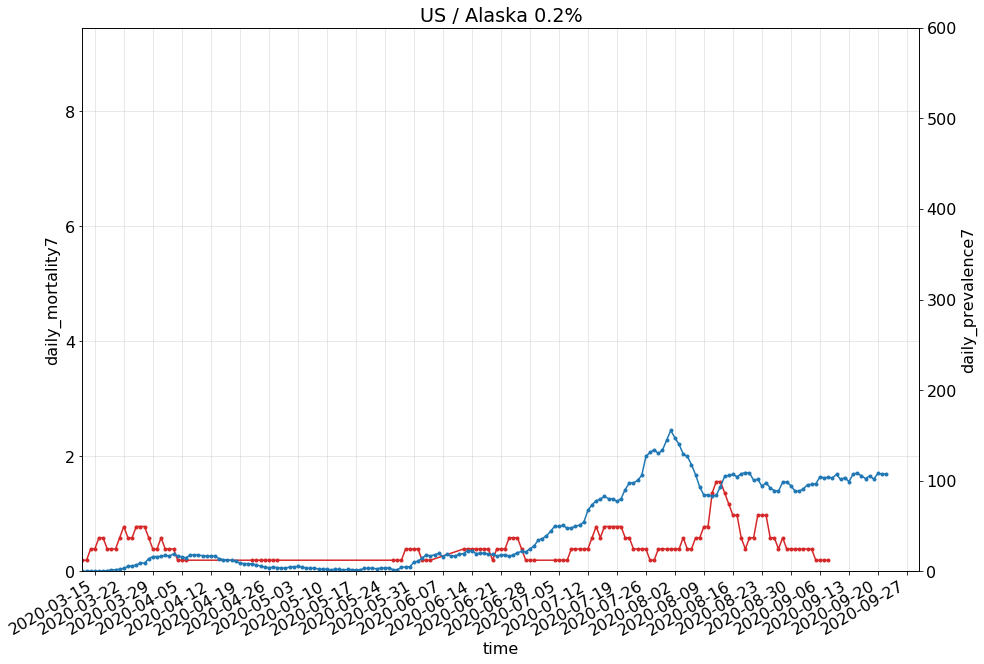

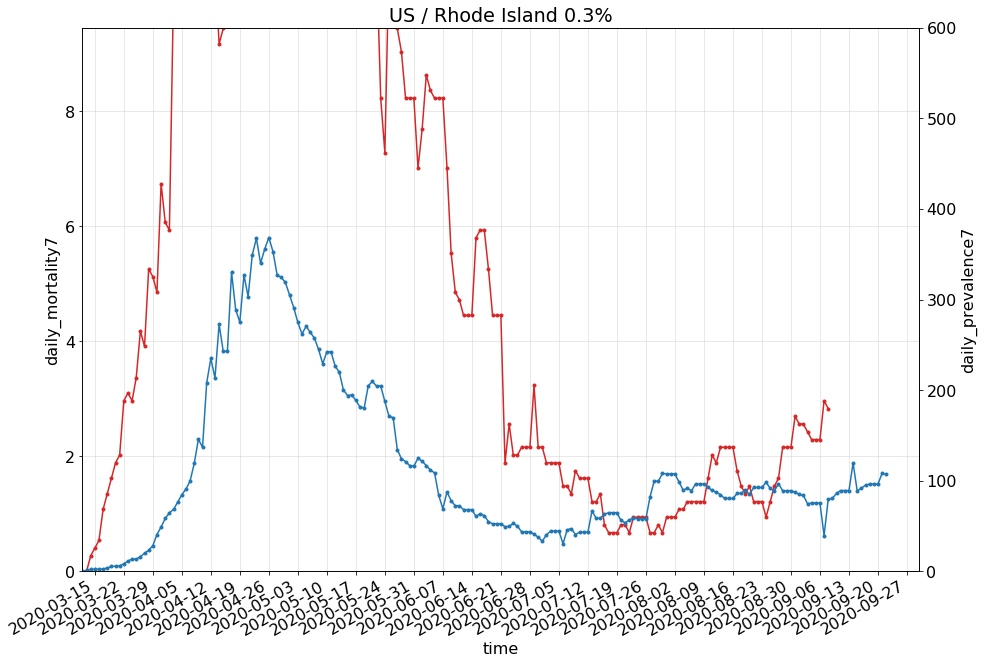

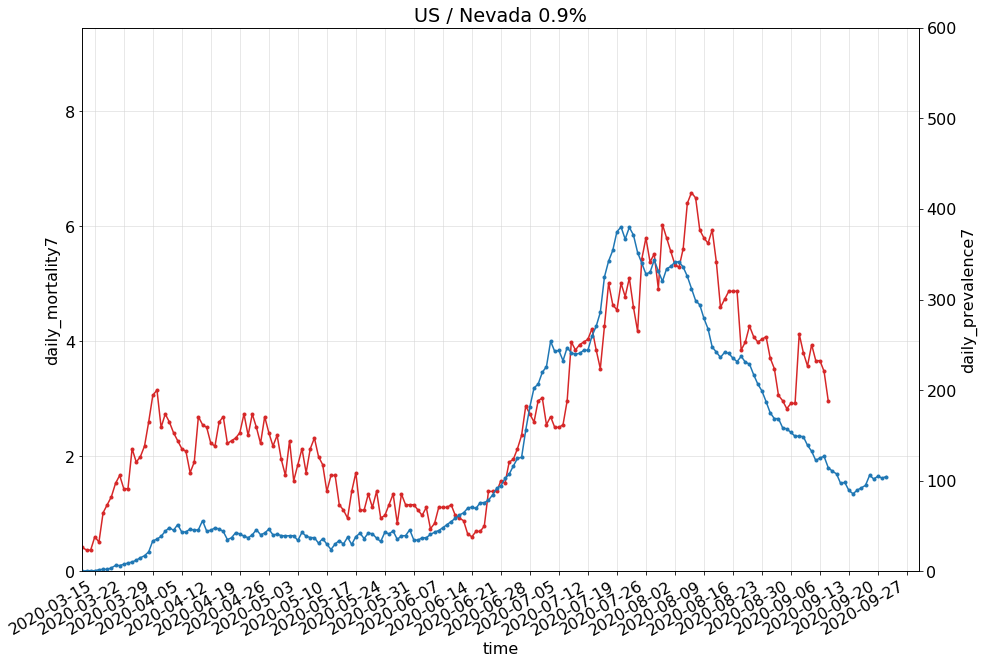

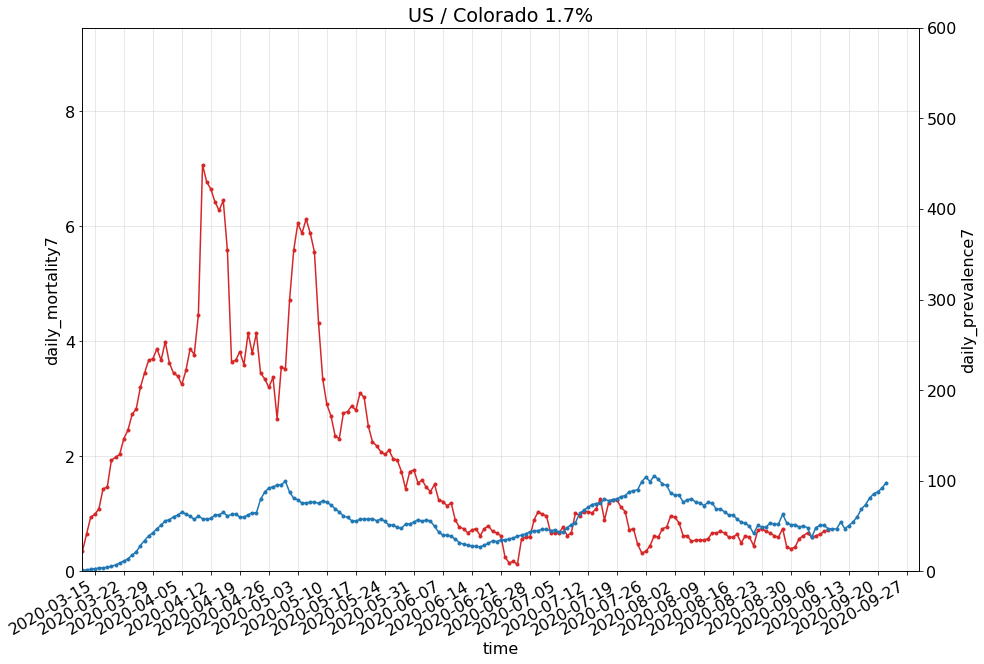

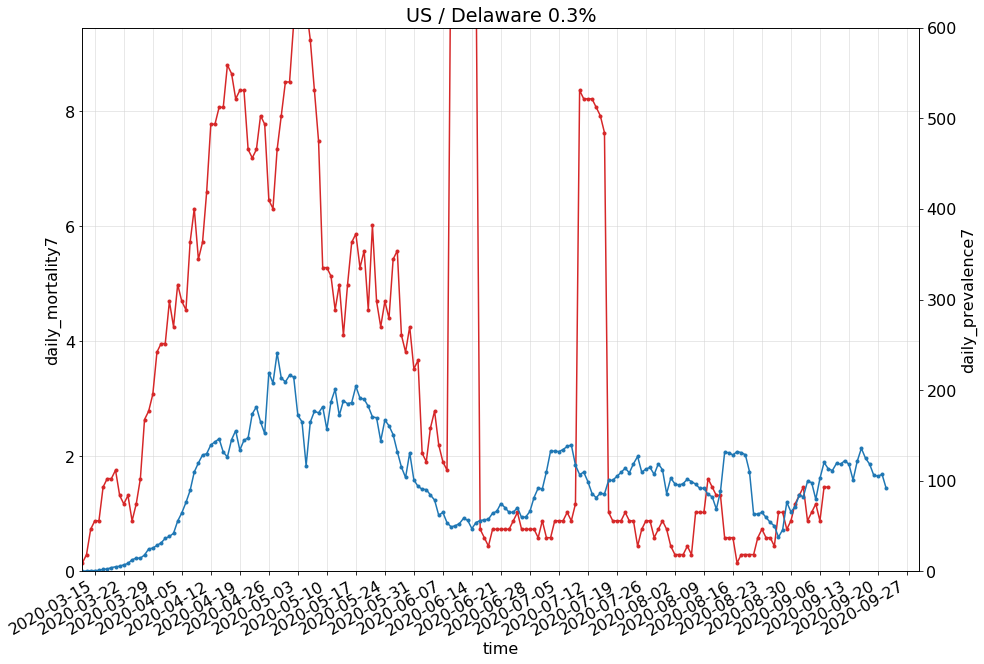

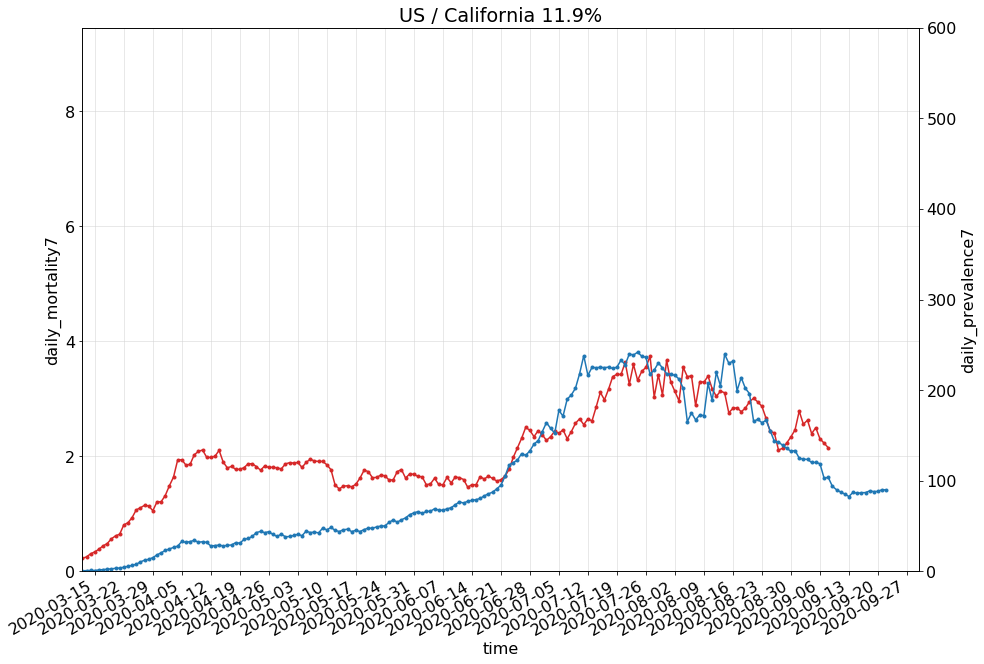

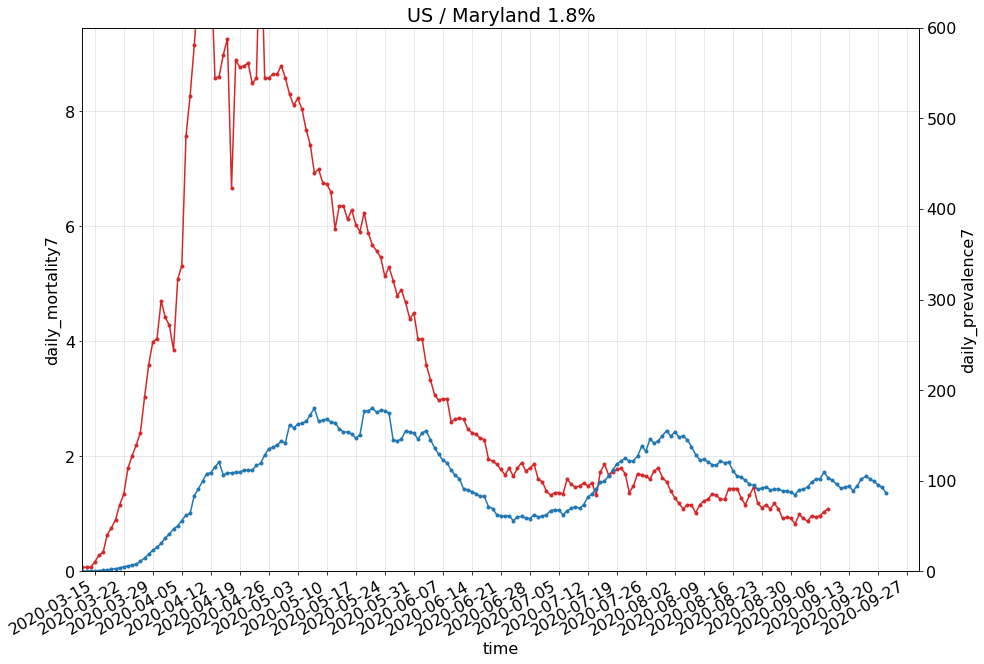

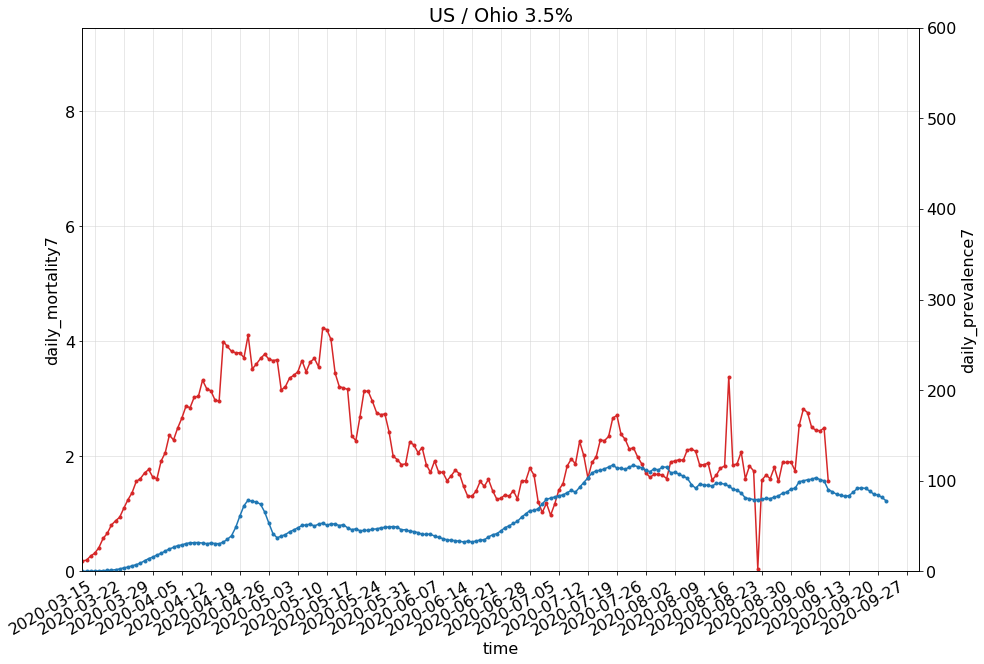

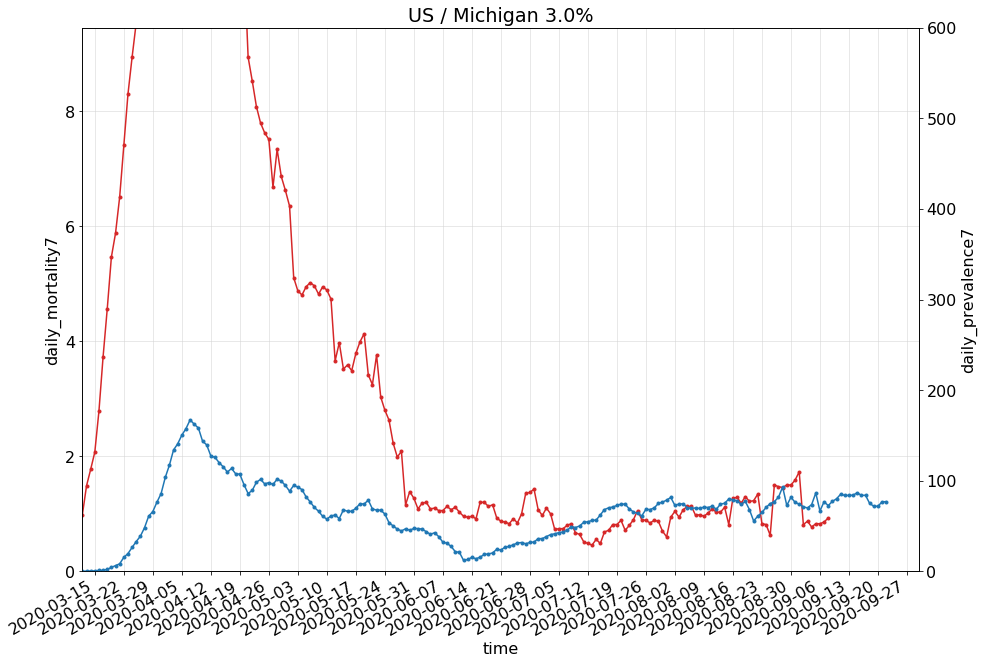

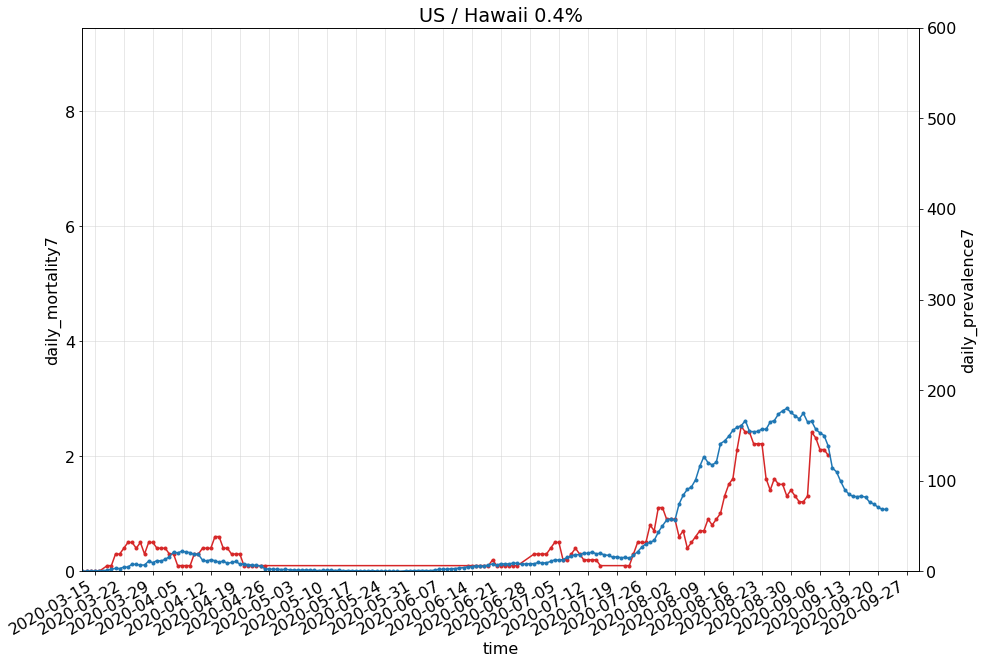

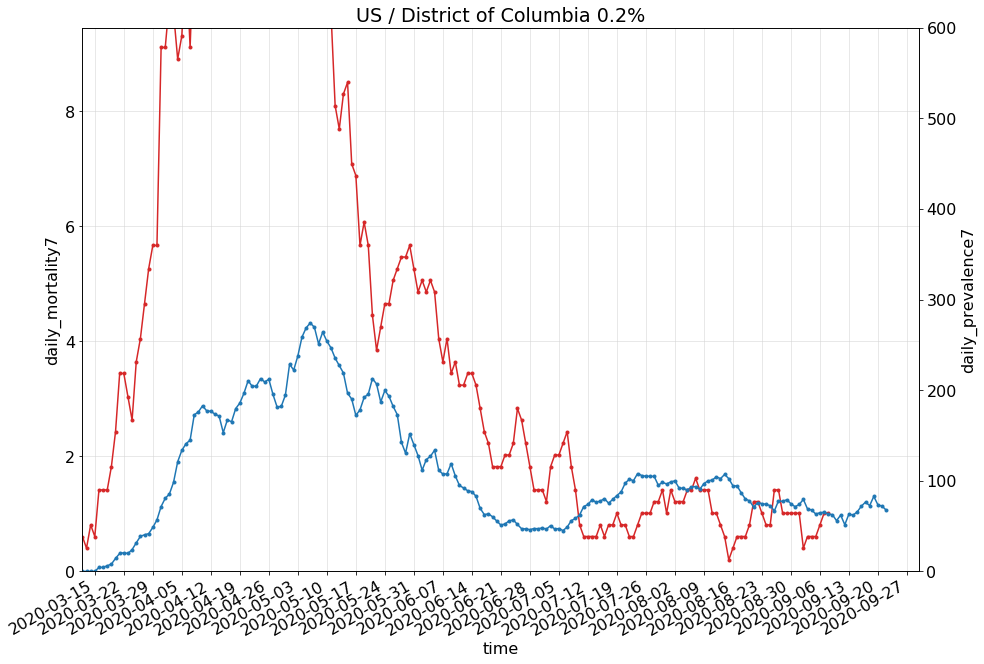

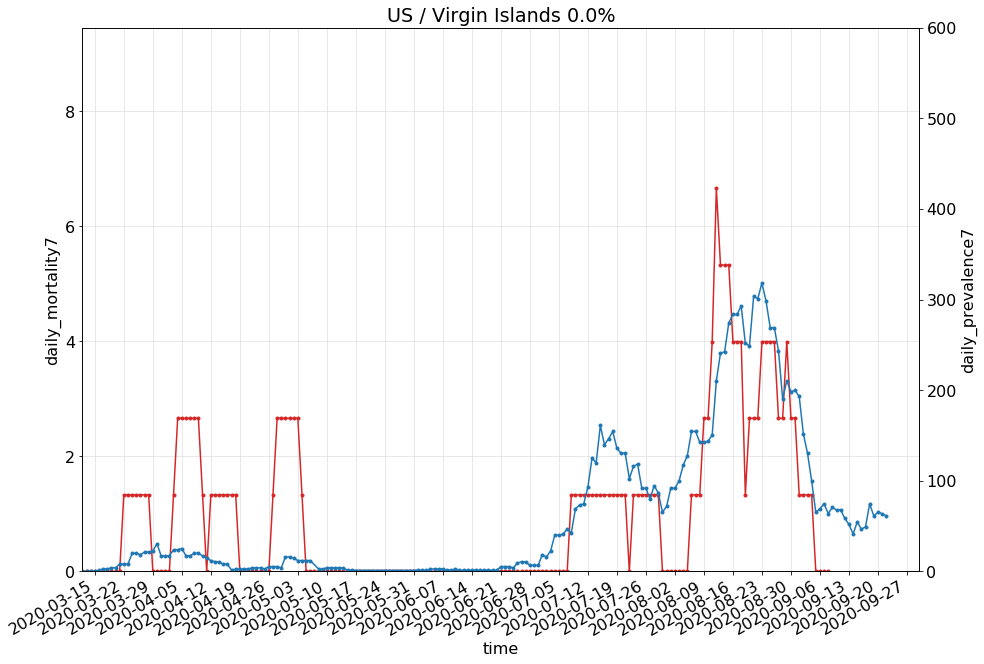

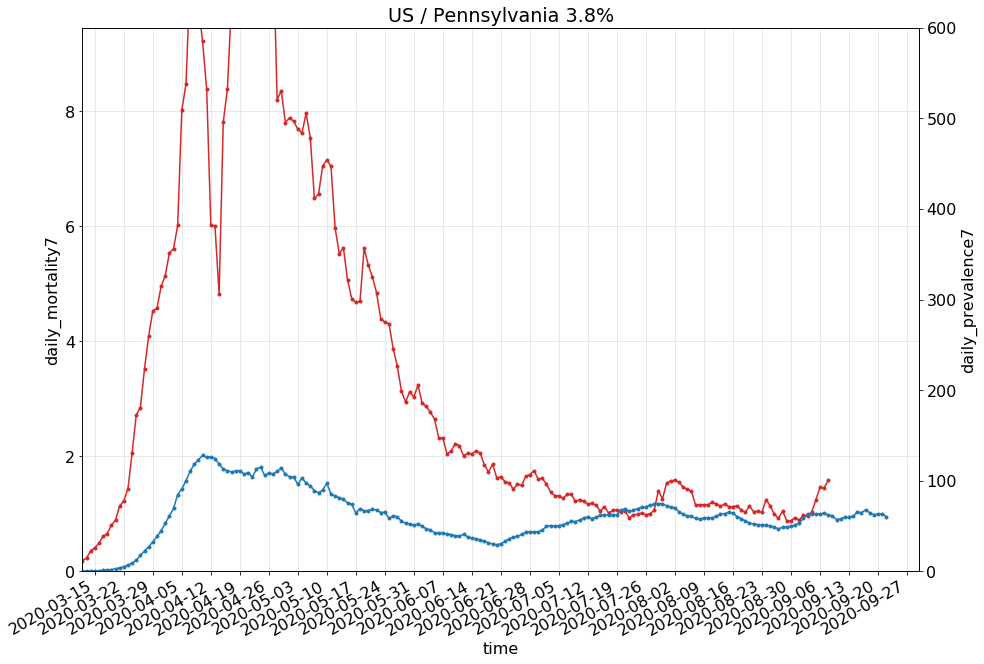

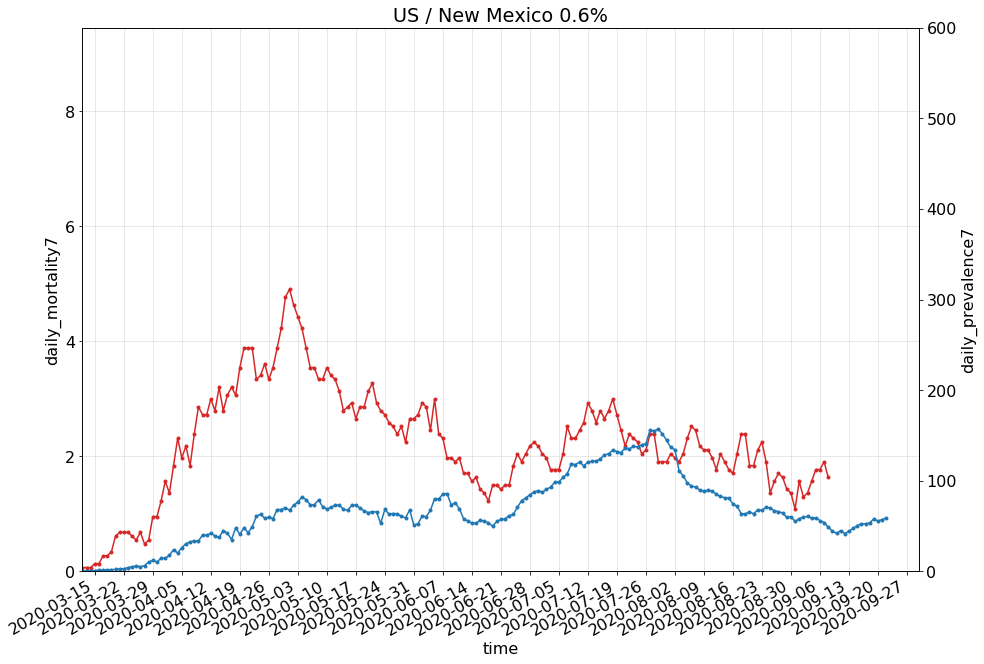

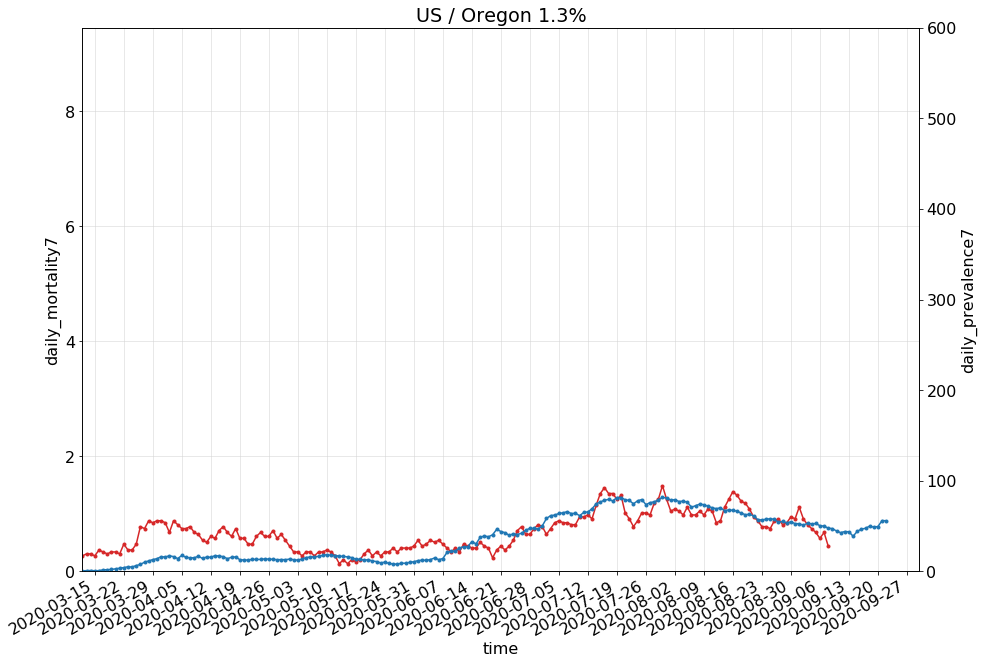

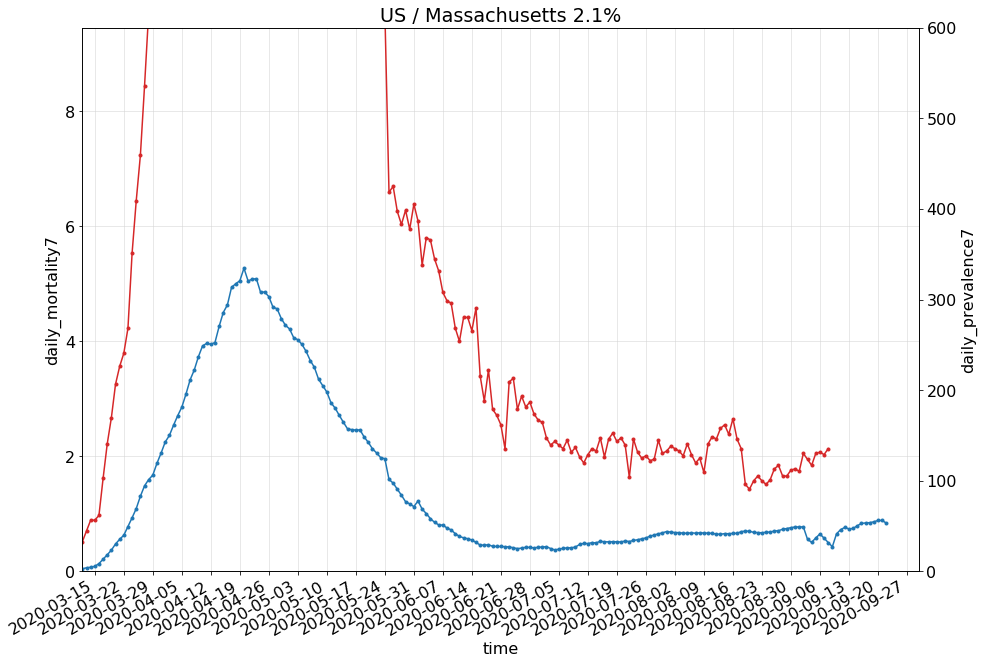

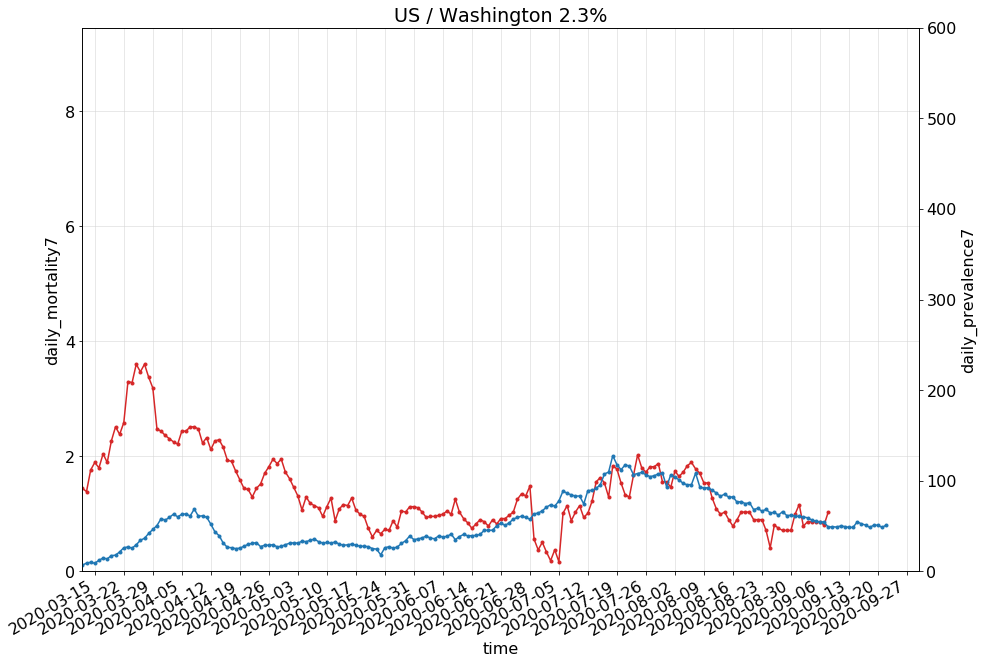

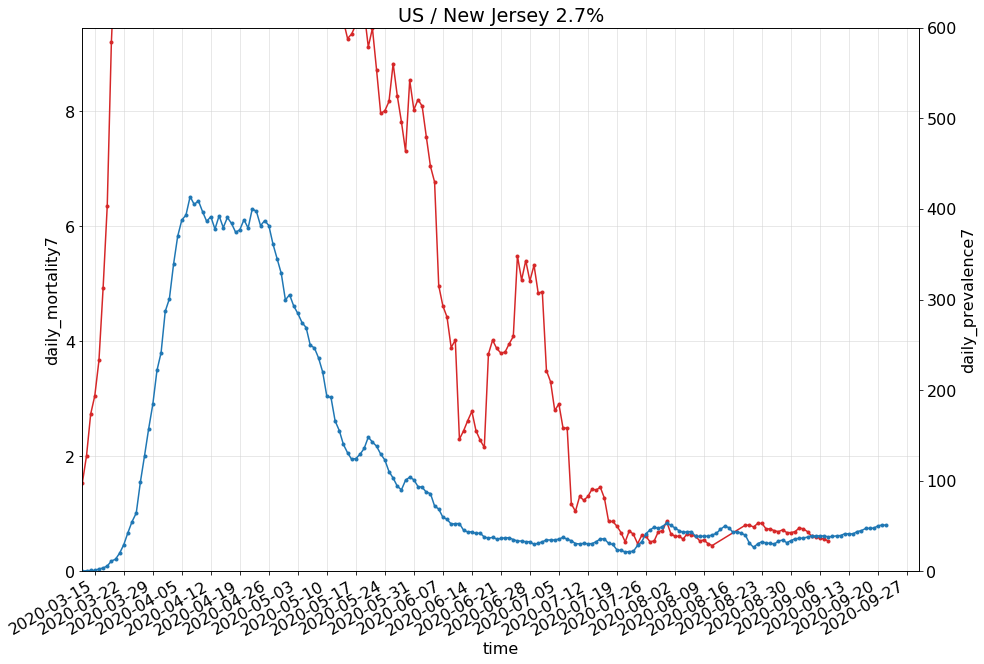

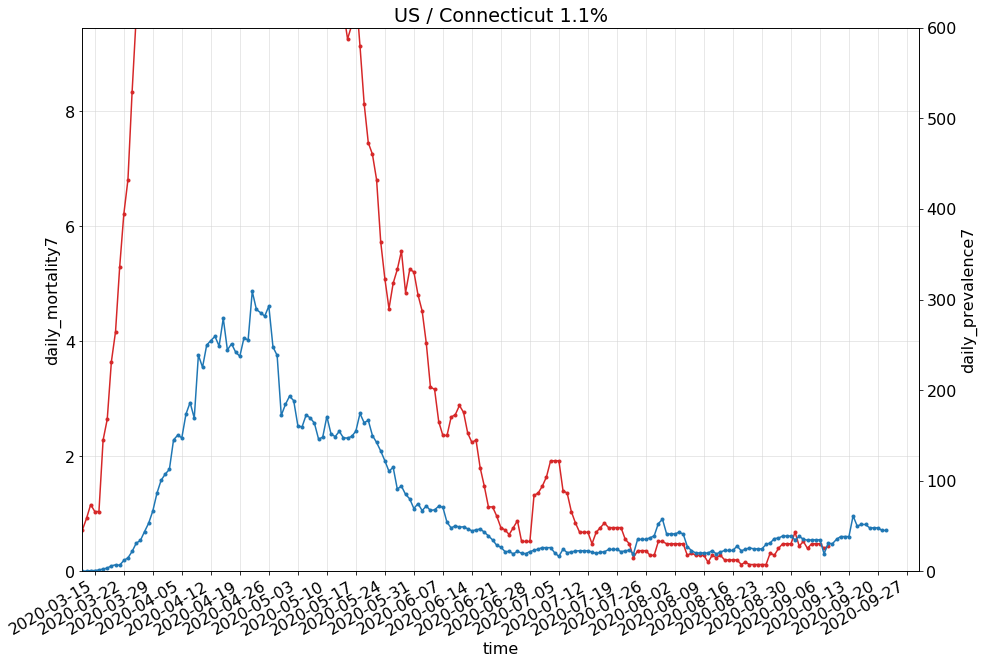

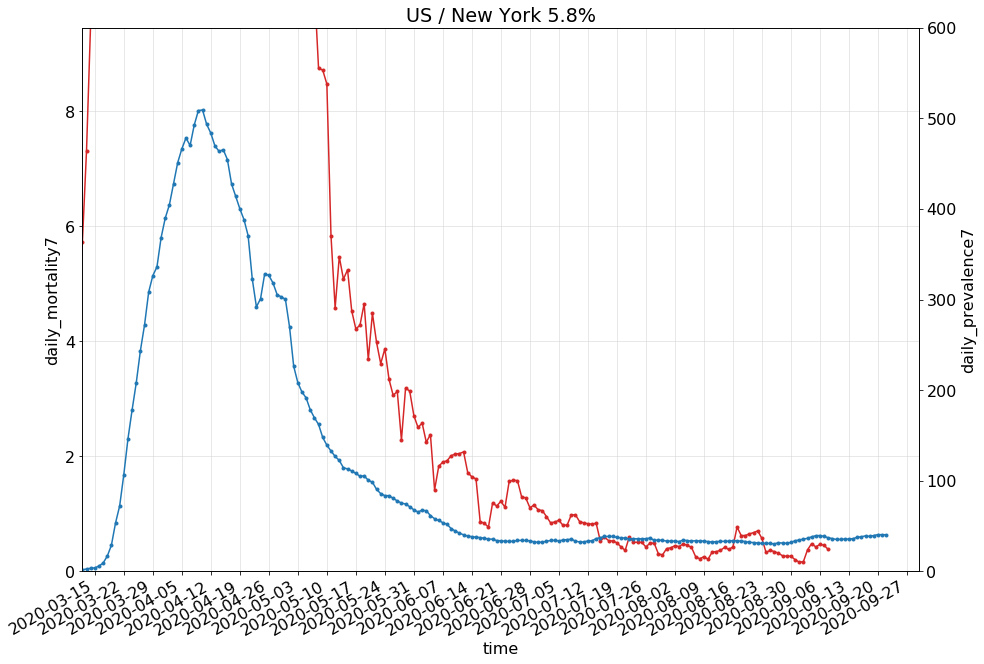

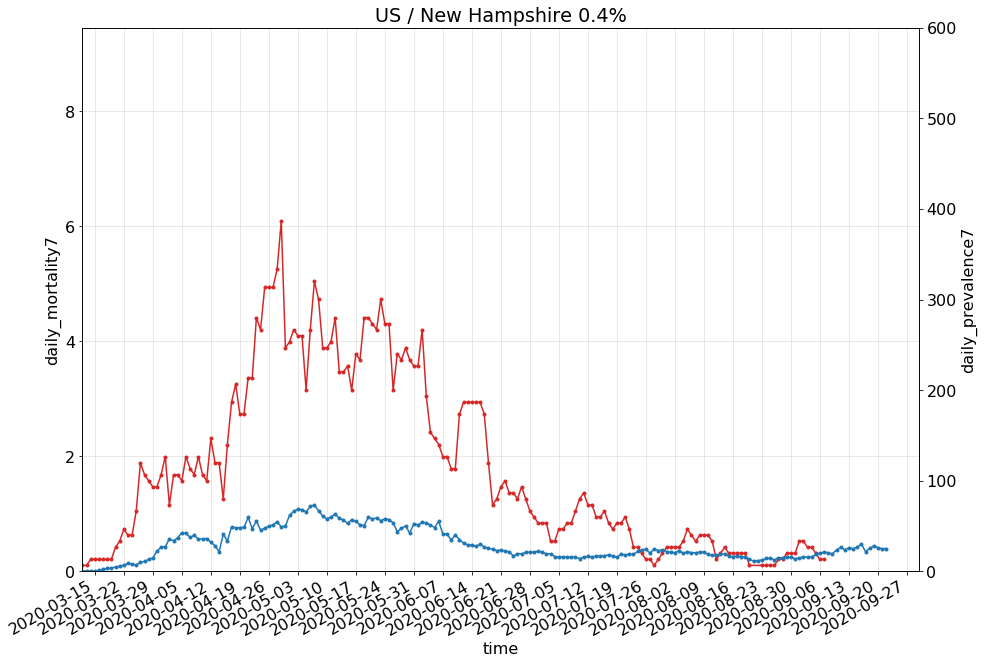

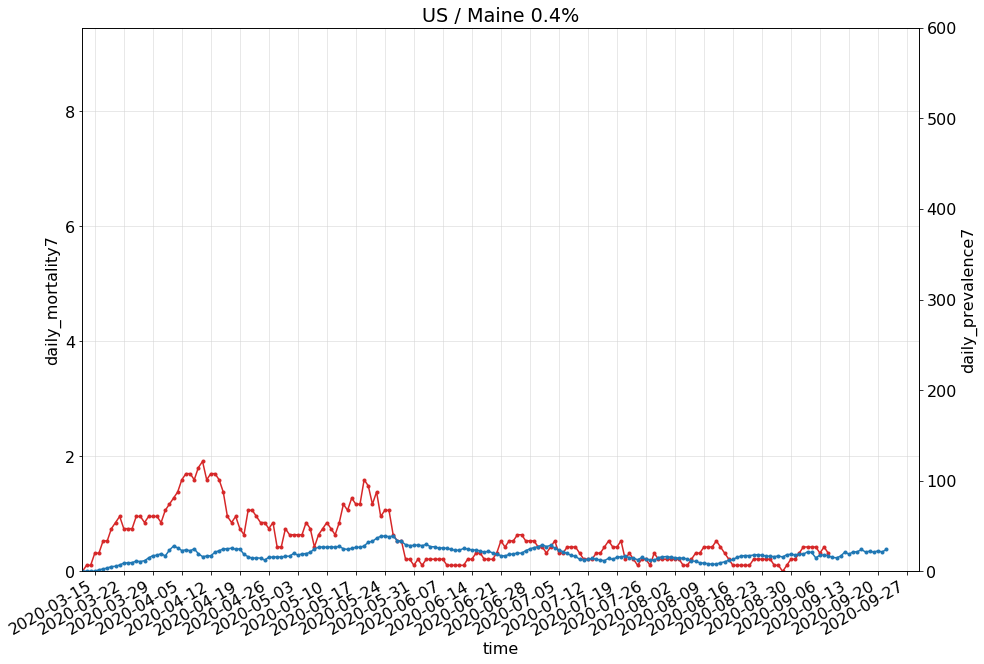

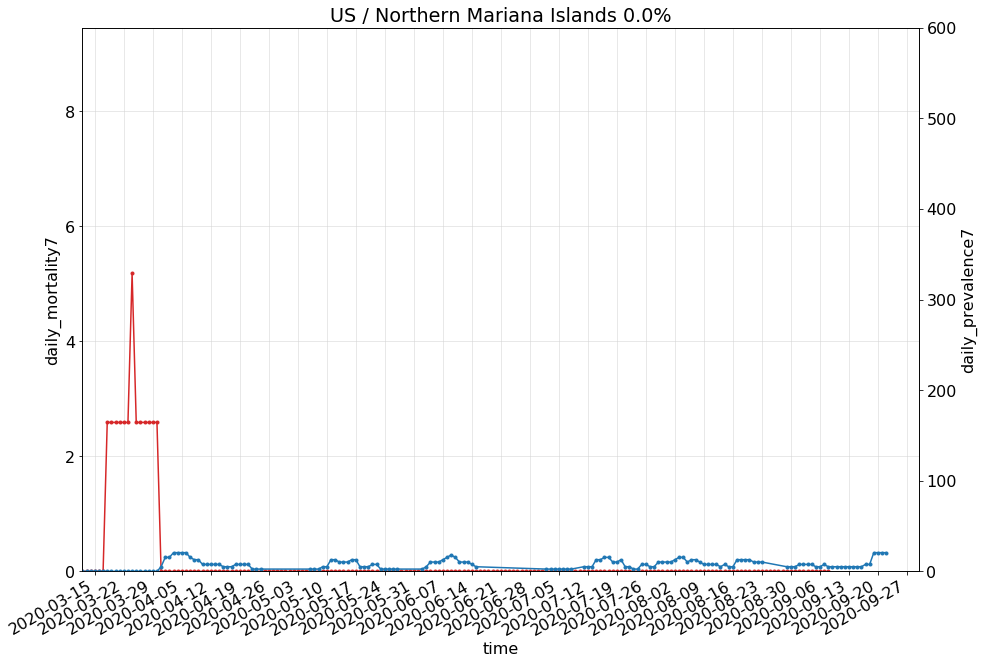

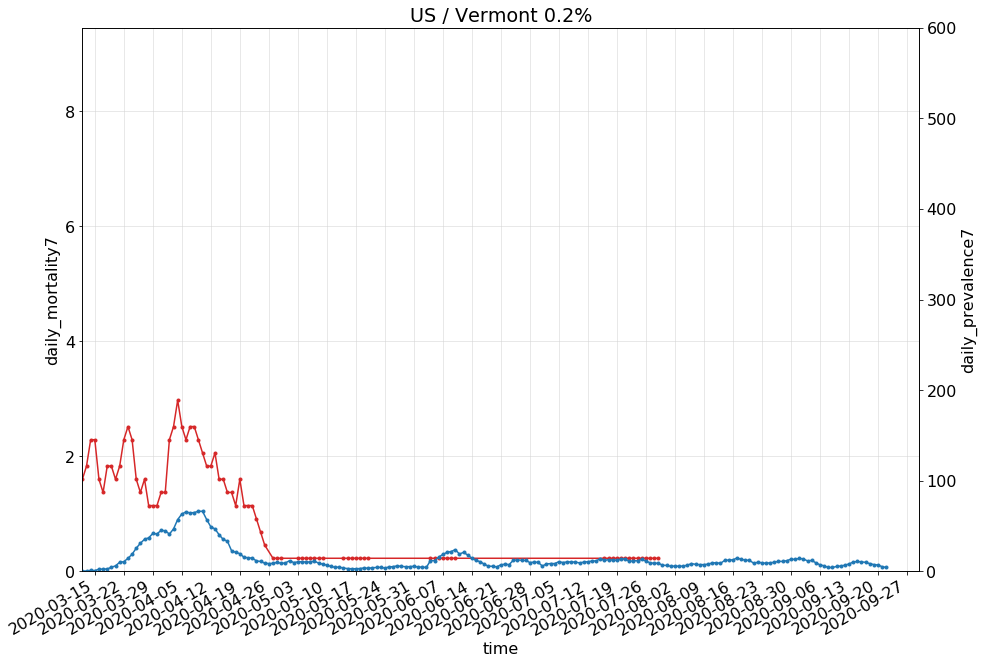

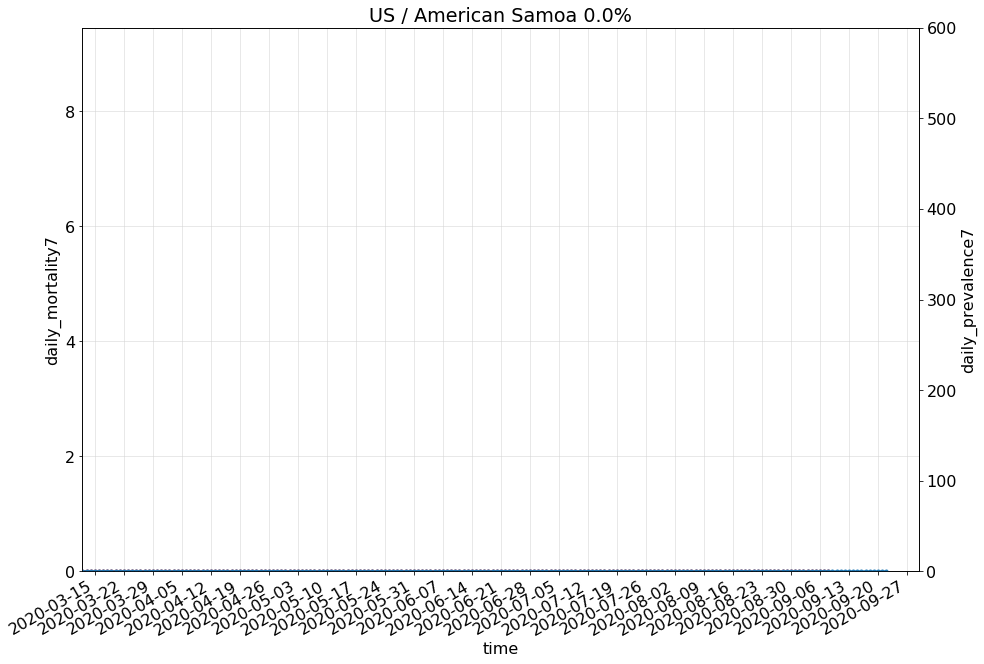

In [152]:
for region in STATES:
    if 'Princess' in region:
        continue
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.set_title(f'COVID-19 {region} - Linear scale')
    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_states.sel(location=region)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 600. * 0.01575), title=f"{region} {ds['population'].values / usa['population'].values * 100:.1f}%")
    ax2.set(ylim=(0, 600.), title=None)